In [1]:
import codecs
from os import path
import pandas as pd
import pdb
import logging
import re
from gensim import parsing
import gensim
from gensim.parsing.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import classification_report

In [2]:
from baal.active import get_heuristic
from baal.active.active_loop import ActiveLearningLoop
from baal.active.dataset.nlp_datasets import active_huggingface_dataset, HuggingFaceDatasets
from baal.bayesian.dropout import patch_module
from baal.transformers_trainer_wrapper import BaalTransformersTrainer
from copy import deepcopy

In [3]:
from sklearn.metrics import accuracy_score

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny") 

In [5]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="transformer_checkpoints",  # specify the directory where models weights will be saved a certain points during training (checkpoints)
    num_train_epochs=1,  # change this if it is taking too long on your computer
)  

In [6]:
def calculate(a):
    rotated = list(zip(*a[::-1]))
    median0 = []
    min0 = []
    max0 = []
    for i in range(len(rotated)):
        median0.append(np.median(rotated[i]))
        min0.append(np.min(rotated[i]))
        max0.append(np.max(rotated[i]))
    return median0,min0,max0

# Abortion

In [7]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_abortion)} instances loaded")

val_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_abortion)} instances loaded")

test_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_abortion)} instances loaded")

num_classes = np.unique(train_dataset_abortion['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 587 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 66 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 280 instances loaded


In [8]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [9]:
active_mc_abortion1= []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_abortion['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
    print(training_indices0)
    active_set_abortion =active_huggingface_dataset(train_dataset_abortion,tokenizer,'label','text')
    valid_set_abortion = HuggingFaceDatasets(test_dataset_abortion,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_abortion.can_label = False
    active_set_abortion.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_abortion,
            eval_dataset=valid_set_abortion,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_abortion = ActiveLearningLoop(active_set_abortion,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_abortion=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_abortion.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_abortion.labelled_map,
            "Next Training set size": len(active_set_abortion),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_abortion.append(eval_metrics['eval_accuracy'])
    print(performance_history_abortion)
    active_mc_abortion1.append(performance_history_abortion)
    mcrun = mcrun + 1

[554 333 154]


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:51:14.276197Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.30it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:51:18.523825Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 37.80it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:51:22.699066Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 37.09it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:51:27.015710Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 33.04it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:51:31.798692Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 39.89it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:51:36.229579Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 39.83it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:51:40.907448Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 34.53it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:51:45.835992Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 38.76it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:51:50.970789Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 37.12it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:51:56.011818Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 39.66it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:52:01.490360Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 35.46it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:52:07.032174Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 36.92it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:52:12.836967Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 41.60it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:52:18.370350Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 36.03it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:52:24.502957Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.38it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:52:30.286851Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 39.98it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:52:36.086757Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 39.09it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:52:42.244512Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 41.11it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:52:48.359479Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 38.05it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:52:54.795927Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 41.90it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:53:01.607689Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.75it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:53:08.364118Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 42.38it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:53:15.318214Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 40.34it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:53:22.372610Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 39.19it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:53:29.959801Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 36.14it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:53:37.866475Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.44it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:53:45.827186Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.99it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:53:53.435858Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 41.89it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:54:01.301793Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.42it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:54:09.647412Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.67it/s]


[0.65, 0.6285714285714286, 0.6607142857142857, 0.6535714285714286, 0.675, 0.675, 0.675, 0.6678571428571428, 0.675, 0.675, 0.675, 0.6785714285714286, 0.675, 0.675, 0.675, 0.675, 0.675, 0.6678571428571428, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]
[535  69 215]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:54:12.810974Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:01<00:00, 36.60it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:54:16.606504Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 34.62it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:54:20.680165Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 38.36it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:54:24.668624Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 37.37it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:54:29.316860Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 38.24it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:54:33.646665Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 39.33it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:54:38.430337Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 36.86it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:54:43.439102Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 39.31it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:54:48.355315Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 37.35it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:54:53.364312Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 39.60it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:54:58.532964Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.50it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:55:04.679015Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 34.15it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:55:10.706517Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 40.38it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:55:17.728236Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 37.36it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:55:25.490032Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 29.97it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:55:33.924893Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 37.16it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:55:40.573926Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 35.75it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:55:47.481876Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 38.40it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:55:54.303122Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 38.14it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:56:01.068978Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 37.36it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:56:07.953182Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.26it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:56:15.080079Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 38.28it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:56:22.221353Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 36.50it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:56:29.503827Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 37.76it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:56:37.104283Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 36.81it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:56:44.594605Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.93it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:56:52.167867Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.93it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:56:59.665820Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 39.08it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:57:08.028702Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 42.64it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:57:16.092583Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.88it/s]


[0.6571428571428571, 0.6642857142857143, 0.6678571428571428, 0.6642857142857143, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]
[535  69 215]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:57:19.448709Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:01<00:00, 38.37it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:57:23.090569Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 38.36it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:57:26.948433Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 39.79it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:57:31.032501Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 36.85it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:57:35.327436Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 39.82it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:57:39.506843Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 36.37it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:57:44.149170Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 37.93it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:57:48.769454Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 38.78it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:57:53.742233Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 34.39it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:57:59.063709Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 35.22it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:58:04.825967Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 35.23it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:58:10.503240Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 37.88it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:58:16.504676Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 40.66it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:58:22.167235Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.83it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:58:27.994727Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 38.96it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:58:33.890186Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 36.80it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:58:40.284678Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.67it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:58:46.882235Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 37.76it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:58:53.026645Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 39.96it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:58:59.278035Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 36.54it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:59:06.732971Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.65it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:59:13.971464Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 37.23it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:59:21.462683Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.96it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:59:29.079882Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 33.20it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:59:37.167405Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 39.16it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:59:45.207591Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.74it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T17:59:53.432396Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.62it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:00:01.272197Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 37.50it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:00:09.977921Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 30.30it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:00:18.659899Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.04it/s]


[0.6571428571428571, 0.6642857142857143, 0.6678571428571428, 0.6642857142857143, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]
[535  69 215]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:00:22.235679Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.69it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:00:26.275677Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 34.44it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:00:30.408721Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 36.54it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:00:34.596113Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 32.68it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:00:39.404498Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 35.33it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:00:44.089550Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 37.80it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:00:48.676523Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 39.95it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:00:53.099233Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 40.18it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:00:58.727438Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 30.49it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:01:05.400512Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 32.45it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:01:12.125148Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 27.19it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:01:18.810960Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 32.12it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:01:25.338461Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.51it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:01:32.268135Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 31.10it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:01:39.395107Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.39it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:01:46.274835Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 30.24it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:01:53.206534Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 32.87it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:02:00.012425Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 36.00it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:02:06.762722Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 39.29it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:02:13.071898Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 40.44it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:02:19.561555Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.42it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:02:26.087156Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 37.64it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:02:33.237478Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 38.24it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:02:40.096257Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 41.53it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:02:47.376833Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 43.79it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:02:54.446106Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 41.50it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:03:01.719683Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.38it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:03:09.401040Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 39.26it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:03:17.143982Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 32.01it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:03:24.936996Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.98it/s]


[0.6571428571428571, 0.6642857142857143, 0.6678571428571428, 0.6642857142857143, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]
[535  69 215]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 3
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:03:28.057379Z [info     ] Start Predict                  dataset=584


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 36.44it/s]
***** Running training *****
  Num examples = 23
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:03:31.793007Z [info     ] Start Predict                  dataset=564


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 37.74it/s]
***** Running training *****
  Num examples = 43
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:03:35.766725Z [info     ] Start Predict                  dataset=544


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 35.52it/s]
***** Running training *****
  Num examples = 63
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:03:39.952958Z [info     ] Start Predict                  dataset=524


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 36.31it/s]
***** Running training *****
  Num examples = 83
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:03:44.168848Z [info     ] Start Predict                  dataset=504


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 37.87it/s]
***** Running training *****
  Num examples = 103
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:03:48.873204Z [info     ] Start Predict                  dataset=484


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 40.10it/s]
***** Running training *****
  Num examples = 123
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:03:53.136794Z [info     ] Start Predict                  dataset=464


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 39.39it/s]
***** Running training *****
  Num examples = 143
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:03:57.839899Z [info     ] Start Predict                  dataset=444


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 38.67it/s]
***** Running training *****
  Num examples = 163
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:04:02.588583Z [info     ] Start Predict                  dataset=424


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 38.64it/s]
***** Running training *****
  Num examples = 183
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:04:07.494914Z [info     ] Start Predict                  dataset=404


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 38.77it/s]
***** Running training *****
  Num examples = 203
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:04:12.623850Z [info     ] Start Predict                  dataset=384


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 37.79it/s]
***** Running training *****
  Num examples = 223
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:04:17.668147Z [info     ] Start Predict                  dataset=364


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 39.92it/s]
***** Running training *****
  Num examples = 243
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:04:23.075135Z [info     ] Start Predict                  dataset=344


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 40.28it/s]
***** Running training *****
  Num examples = 263
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:04:28.640979Z [info     ] Start Predict                  dataset=324


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 36.81it/s]
***** Running training *****
  Num examples = 283
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:04:35.162237Z [info     ] Start Predict                  dataset=304


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 40.36it/s]
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:04:41.151533Z [info     ] Start Predict                  dataset=284


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 38.03it/s]
***** Running training *****
  Num examples = 323
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:04:47.278483Z [info     ] Start Predict                  dataset=264


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 40.21it/s]
***** Running training *****
  Num examples = 343
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:04:53.455287Z [info     ] Start Predict                  dataset=244


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 39.55it/s]
***** Running training *****
  Num examples = 363
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:04:59.798101Z [info     ] Start Predict                  dataset=224


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 37.28it/s]
***** Running training *****
  Num examples = 383
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:05:06.262104Z [info     ] Start Predict                  dataset=204


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 39.47it/s]
***** Running training *****
  Num examples = 403
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:05:12.986937Z [info     ] Start Predict                  dataset=184


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.88it/s]
***** Running training *****
  Num examples = 423
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:05:19.835831Z [info     ] Start Predict                  dataset=164


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 39.58it/s]
***** Running training *****
  Num examples = 443
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:05:26.861058Z [info     ] Start Predict                  dataset=144


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 38.56it/s]
***** Running training *****
  Num examples = 463
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:05:33.975718Z [info     ] Start Predict                  dataset=124


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 39.14it/s]
***** Running training *****
  Num examples = 483
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:05:41.389875Z [info     ] Start Predict                  dataset=104


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 41.38it/s]
***** Running training *****
  Num examples = 503
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:05:48.929963Z [info     ] Start Predict                  dataset=84


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 41.02it/s]
***** Running training *****
  Num examples = 523
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:05:56.674836Z [info     ] Start Predict                  dataset=64


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.39it/s]
***** Running training *****
  Num examples = 543
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:06:04.454334Z [info     ] Start Predict                  dataset=44


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 42.67it/s]
***** Running training *****
  Num examples = 563
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:06:12.270901Z [info     ] Start Predict                  dataset=24


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 31.51it/s]
***** Running training *****
  Num examples = 583
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:06:20.672345Z [info     ] Start Predict                  dataset=4


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 32.00it/s]


[0.6571428571428571, 0.6642857142857143, 0.6678571428571428, 0.6642857142857143, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]


In [10]:
median_abortion1, min_abortion1,max_abortion1 = calculate(active_mc_abortion1)

In [11]:
active_mc_abortion2= []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_abortion['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=20)
    print(training_indices0)
    active_set_abortion =active_huggingface_dataset(train_dataset_abortion,tokenizer,'label','text')
    valid_set_abortion = HuggingFaceDatasets(test_dataset_abortion,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_abortion.can_label = False
    active_set_abortion.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_abortion,
            eval_dataset=valid_set_abortion,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_abortion = ActiveLearningLoop(active_set_abortion,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_abortion=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_abortion.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_abortion.labelled_map,
            "Next Training set size": len(active_set_abortion),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_abortion.append(eval_metrics['eval_accuracy'])
    print(performance_history_abortion)
    active_mc_abortion2.append(performance_history_abortion)
    mcrun = mcrun + 1

[ 98 248 342 190 289 495 102 318 349 429  79  69 346 182 456 250 563 230
 272 348]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 20
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 20
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:06:23.971914Z [info     ] Start Predict                  dataset=567


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 39.84it/s]
***** Running training *****
  Num examples = 40
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:06:27.711212Z [info     ] Start Predict                  dataset=547


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 40.34it/s]
***** Running training *****
  Num examples = 60
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:06:31.521483Z [info     ] Start Predict                  dataset=527


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 38.98it/s]
***** Running training *****
  Num examples = 80
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:06:35.611971Z [info     ] Start Predict                  dataset=507


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 40.41it/s]
***** Running training *****
  Num examples = 100
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:06:39.780734Z [info     ] Start Predict                  dataset=487


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 37.94it/s]
***** Running training *****
  Num examples = 120
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:06:44.219482Z [info     ] Start Predict                  dataset=467


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 40.74it/s]
***** Running training *****
  Num examples = 140
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:06:48.779891Z [info     ] Start Predict                  dataset=447


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 40.62it/s]
***** Running training *****
  Num examples = 160
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:06:53.420868Z [info     ] Start Predict                  dataset=427


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 39.43it/s]
***** Running training *****
  Num examples = 180
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:06:58.263271Z [info     ] Start Predict                  dataset=407


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 38.70it/s]
***** Running training *****
  Num examples = 200
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:07:03.185688Z [info     ] Start Predict                  dataset=387


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 39.55it/s]
***** Running training *****
  Num examples = 220
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:07:08.217060Z [info     ] Start Predict                  dataset=367


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 39.92it/s]
***** Running training *****
  Num examples = 240
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:07:13.296344Z [info     ] Start Predict                  dataset=347


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 39.99it/s]
***** Running training *****
  Num examples = 260
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:07:18.705621Z [info     ] Start Predict                  dataset=327


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 40.84it/s]
***** Running training *****
  Num examples = 280
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:07:24.315515Z [info     ] Start Predict                  dataset=307


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 42.53it/s]
***** Running training *****
  Num examples = 300
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:07:30.108487Z [info     ] Start Predict                  dataset=287


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 42.15it/s]
***** Running training *****
  Num examples = 320
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 40


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:07:35.892393Z [info     ] Start Predict                  dataset=267


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 42.04it/s]
***** Running training *****
  Num examples = 340
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:07:41.778945Z [info     ] Start Predict                  dataset=247


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 39.58it/s]
***** Running training *****
  Num examples = 360
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:07:48.002001Z [info     ] Start Predict                  dataset=227


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 37.19it/s]
***** Running training *****
  Num examples = 380
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:07:54.993800Z [info     ] Start Predict                  dataset=207


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 36.11it/s]
***** Running training *****
  Num examples = 400
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:08:02.031447Z [info     ] Start Predict                  dataset=187


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 35.57it/s]
***** Running training *****
  Num examples = 420
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:08:09.179478Z [info     ] Start Predict                  dataset=167


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 40.61it/s]
***** Running training *****
  Num examples = 440
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 55


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:08:16.247986Z [info     ] Start Predict                  dataset=147


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 40.90it/s]
***** Running training *****
  Num examples = 460
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:08:23.851764Z [info     ] Start Predict                  dataset=127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 39.38it/s]
***** Running training *****
  Num examples = 480
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 60


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:08:31.329208Z [info     ] Start Predict                  dataset=107


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 38.96it/s]
***** Running training *****
  Num examples = 500
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:08:38.822244Z [info     ] Start Predict                  dataset=87


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 36.91it/s]
***** Running training *****
  Num examples = 520
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 65


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:08:46.502568Z [info     ] Start Predict                  dataset=67


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 40.87it/s]
***** Running training *****
  Num examples = 540
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:08:54.176512Z [info     ] Start Predict                  dataset=47


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 42.67it/s]
***** Running training *****
  Num examples = 560
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 70


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:09:03.203738Z [info     ] Start Predict                  dataset=27


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33.61it/s]
***** Running training *****
  Num examples = 580
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:09:12.113552Z [info     ] Start Predict                  dataset=7


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.6571428571428571, 0.6642857142857143, 0.6607142857142857, 0.6714285714285714, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]
[365  93 372 338 436 335 491  39 358 573 253 580 397 169 510 259 583 458
 528 340]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 20
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 20
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:09:25.453455Z [info     ] Start Predict                  dataset=567


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 31.60it/s]
***** Running training *****
  Num examples = 40
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:09:29.732521Z [info     ] Start Predict                  dataset=547


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 33.32it/s]
***** Running training *****
  Num examples = 60
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:09:34.149441Z [info     ] Start Predict                  dataset=527


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 31.75it/s]
***** Running training *****
  Num examples = 80
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:09:39.345441Z [info     ] Start Predict                  dataset=507


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:02<00:00, 31.71it/s]
***** Running training *****
  Num examples = 100
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:09:44.422440Z [info     ] Start Predict                  dataset=487


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 34.72it/s]
***** Running training *****
  Num examples = 120
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:09:49.009512Z [info     ] Start Predict                  dataset=467


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 32.49it/s]
***** Running training *****
  Num examples = 140
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:09:54.244405Z [info     ] Start Predict                  dataset=447


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 33.99it/s]
***** Running training *****
  Num examples = 160
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:09:59.288001Z [info     ] Start Predict                  dataset=427


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 30.01it/s]
***** Running training *****
  Num examples = 180
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:10:06.090172Z [info     ] Start Predict                  dataset=407


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 31.78it/s]
***** Running training *****
  Num examples = 200
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:10:12.135036Z [info     ] Start Predict                  dataset=387


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 28.34it/s]
***** Running training *****
  Num examples = 220
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:10:20.294037Z [info     ] Start Predict                  dataset=367


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 30.73it/s]
***** Running training *****
  Num examples = 240
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:10:26.910737Z [info     ] Start Predict                  dataset=347


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 31.37it/s]
***** Running training *****
  Num examples = 260
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:10:33.341107Z [info     ] Start Predict                  dataset=327


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 34.96it/s]
***** Running training *****
  Num examples = 280
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:10:40.467703Z [info     ] Start Predict                  dataset=307


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.32it/s]
***** Running training *****
  Num examples = 300
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:10:47.009117Z [info     ] Start Predict                  dataset=287


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 34.48it/s]
***** Running training *****
  Num examples = 320
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 40


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:10:53.401494Z [info     ] Start Predict                  dataset=267


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 36.75it/s]
***** Running training *****
  Num examples = 340
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:11:00.203949Z [info     ] Start Predict                  dataset=247


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 33.75it/s]
***** Running training *****
  Num examples = 360
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:11:06.755971Z [info     ] Start Predict                  dataset=227


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 35.84it/s]
***** Running training *****
  Num examples = 380
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:11:13.801276Z [info     ] Start Predict                  dataset=207


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 32.48it/s]
***** Running training *****
  Num examples = 400
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:11:21.890127Z [info     ] Start Predict                  dataset=187


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 27.00it/s]
***** Running training *****
  Num examples = 420
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:11:29.993442Z [info     ] Start Predict                  dataset=167


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 31.25it/s]
***** Running training *****
  Num examples = 440
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 55


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:11:38.458883Z [info     ] Start Predict                  dataset=147


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 35.66it/s]
***** Running training *****
  Num examples = 460
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:11:47.650139Z [info     ] Start Predict                  dataset=127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 20.00it/s]
***** Running training *****
  Num examples = 480
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 60


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:11:56.595474Z [info     ] Start Predict                  dataset=107


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.91it/s]
***** Running training *****
  Num examples = 500
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:12:04.779115Z [info     ] Start Predict                  dataset=87


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.20it/s]
***** Running training *****
  Num examples = 520
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 65


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:12:13.275564Z [info     ] Start Predict                  dataset=67


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 36.17it/s]
***** Running training *****
  Num examples = 540
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:12:22.053317Z [info     ] Start Predict                  dataset=47


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 34.38it/s]
***** Running training *****
  Num examples = 560
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 70


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:12:31.268844Z [info     ] Start Predict                  dataset=27


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.40it/s]
***** Running training *****
  Num examples = 580
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:12:40.157776Z [info     ] Start Predict                  dataset=7


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.53it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.6428571428571429, 0.6571428571428571, 0.6571428571428571, 0.6678571428571428, 0.675, 0.675, 0.675, 0.675, 0.6785714285714286, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]
[365  93 372 338 436 335 491  39 358 573 253 580 397 169 510 259 583 458
 528 340]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 20
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 20
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:12:52.309510Z [info     ] Start Predict                  dataset=567


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 35.17it/s]
***** Running training *****
  Num examples = 40
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:12:56.384532Z [info     ] Start Predict                  dataset=547


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 36.61it/s]
***** Running training *****
  Num examples = 60
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:13:00.735092Z [info     ] Start Predict                  dataset=527


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 36.84it/s]
***** Running training *****
  Num examples = 80
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:13:05.158615Z [info     ] Start Predict                  dataset=507


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 33.62it/s]
***** Running training *****
  Num examples = 100
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:13:11.092231Z [info     ] Start Predict                  dataset=487


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 28.83it/s]
***** Running training *****
  Num examples = 120
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:13:16.634754Z [info     ] Start Predict                  dataset=467


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 35.13it/s]
***** Running training *****
  Num examples = 140
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:13:21.691794Z [info     ] Start Predict                  dataset=447


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 37.29it/s]
***** Running training *****
  Num examples = 160
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:13:26.783524Z [info     ] Start Predict                  dataset=427


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 37.11it/s]
***** Running training *****
  Num examples = 180
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:13:32.012400Z [info     ] Start Predict                  dataset=407


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 35.20it/s]
***** Running training *****
  Num examples = 200
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:13:37.400704Z [info     ] Start Predict                  dataset=387


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 36.72it/s]
***** Running training *****
  Num examples = 220
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:13:43.105062Z [info     ] Start Predict                  dataset=367


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 33.20it/s]
***** Running training *****
  Num examples = 240
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:13:48.970122Z [info     ] Start Predict                  dataset=347


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.87it/s]
***** Running training *****
  Num examples = 260
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:13:55.118732Z [info     ] Start Predict                  dataset=327


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 35.47it/s]
***** Running training *****
  Num examples = 280
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:14:01.771932Z [info     ] Start Predict                  dataset=307


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.11it/s]
***** Running training *****
  Num examples = 300
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:14:08.359027Z [info     ] Start Predict                  dataset=287


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 36.71it/s]
***** Running training *****
  Num examples = 320
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 40


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:14:14.695668Z [info     ] Start Predict                  dataset=267


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.79it/s]
***** Running training *****
  Num examples = 340
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:14:21.651324Z [info     ] Start Predict                  dataset=247


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 35.74it/s]
***** Running training *****
  Num examples = 360
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:14:28.319309Z [info     ] Start Predict                  dataset=227


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 34.33it/s]
***** Running training *****
  Num examples = 380
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:14:36.257182Z [info     ] Start Predict                  dataset=207


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 33.90it/s]
***** Running training *****
  Num examples = 400
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:14:44.237051Z [info     ] Start Predict                  dataset=187


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 35.66it/s]
***** Running training *****
  Num examples = 420
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:14:51.347133Z [info     ] Start Predict                  dataset=167


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 38.24it/s]
***** Running training *****
  Num examples = 440
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 55


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:14:58.190017Z [info     ] Start Predict                  dataset=147


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 40.53it/s]
***** Running training *****
  Num examples = 460
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:15:05.578515Z [info     ] Start Predict                  dataset=127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31.90it/s]
***** Running training *****
  Num examples = 480
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 60


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:15:13.544564Z [info     ] Start Predict                  dataset=107


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 38.75it/s]
***** Running training *****
  Num examples = 500
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:15:21.021291Z [info     ] Start Predict                  dataset=87


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 46.55it/s]
***** Running training *****
  Num examples = 520
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 65


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:15:28.624730Z [info     ] Start Predict                  dataset=67


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 44.31it/s]
***** Running training *****
  Num examples = 540
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:15:36.431592Z [info     ] Start Predict                  dataset=47


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 42.00it/s]
***** Running training *****
  Num examples = 560
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 70


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:15:44.358094Z [info     ] Start Predict                  dataset=27


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 50.47it/s]
***** Running training *****
  Num examples = 580
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:15:53.256738Z [info     ] Start Predict                  dataset=7


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.47it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.6428571428571429, 0.6571428571428571, 0.6571428571428571, 0.6678571428571428, 0.675, 0.675, 0.675, 0.675, 0.6785714285714286, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]
[365  93 372 338 436 335 491  39 358 573 253 580 397 169 510 259 583 458
 528 340]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 20
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 20
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:16:05.575901Z [info     ] Start Predict                  dataset=567


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 34.16it/s]
***** Running training *****
  Num examples = 40
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:16:10.291410Z [info     ] Start Predict                  dataset=547


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 29.70it/s]
***** Running training *****
  Num examples = 60
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:16:15.069987Z [info     ] Start Predict                  dataset=527


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 32.16it/s]
***** Running training *****
  Num examples = 80
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:16:21.155151Z [info     ] Start Predict                  dataset=507


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 35.28it/s]
***** Running training *****
  Num examples = 100
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:16:26.258335Z [info     ] Start Predict                  dataset=487


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 27.62it/s]
***** Running training *****
  Num examples = 120
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:16:32.559940Z [info     ] Start Predict                  dataset=467


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:02<00:00, 28.20it/s]
***** Running training *****
  Num examples = 140
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:16:38.776178Z [info     ] Start Predict                  dataset=447


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 23.11it/s]
***** Running training *****
  Num examples = 160
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:16:45.414036Z [info     ] Start Predict                  dataset=427


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 28.12it/s]
***** Running training *****
  Num examples = 180
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:16:51.552125Z [info     ] Start Predict                  dataset=407


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 37.38it/s]
***** Running training *****
  Num examples = 200
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:16:57.206461Z [info     ] Start Predict                  dataset=387


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 37.45it/s]
***** Running training *****
  Num examples = 220
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:17:02.921083Z [info     ] Start Predict                  dataset=367


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 31.09it/s]
***** Running training *****
  Num examples = 240
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:17:08.779634Z [info     ] Start Predict                  dataset=347


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 39.28it/s]
***** Running training *****
  Num examples = 260
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:17:14.439048Z [info     ] Start Predict                  dataset=327


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 35.99it/s]
***** Running training *****
  Num examples = 280
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:17:20.691873Z [info     ] Start Predict                  dataset=307


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.18it/s]
***** Running training *****
  Num examples = 300
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:17:28.547346Z [info     ] Start Predict                  dataset=287


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 29.95it/s]
***** Running training *****
  Num examples = 320
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 40


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:17:36.289657Z [info     ] Start Predict                  dataset=267


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 36.91it/s]
***** Running training *****
  Num examples = 340
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:17:42.696140Z [info     ] Start Predict                  dataset=247


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 39.68it/s]
***** Running training *****
  Num examples = 360
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:17:49.233690Z [info     ] Start Predict                  dataset=227


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 34.47it/s]
***** Running training *****
  Num examples = 380
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:17:55.858450Z [info     ] Start Predict                  dataset=207


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 38.25it/s]
***** Running training *****
  Num examples = 400
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:18:03.049126Z [info     ] Start Predict                  dataset=187


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 37.46it/s]
***** Running training *****
  Num examples = 420
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:18:10.009791Z [info     ] Start Predict                  dataset=167


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 37.33it/s]
***** Running training *****
  Num examples = 440
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 55


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:18:18.269232Z [info     ] Start Predict                  dataset=147


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.45it/s]
***** Running training *****
  Num examples = 460
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:18:26.691420Z [info     ] Start Predict                  dataset=127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 32.79it/s]
***** Running training *****
  Num examples = 480
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 60


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:18:34.734600Z [info     ] Start Predict                  dataset=107


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.60it/s]
***** Running training *****
  Num examples = 500
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:18:43.389208Z [info     ] Start Predict                  dataset=87


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.54it/s]
***** Running training *****
  Num examples = 520
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 65


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:18:51.336438Z [info     ] Start Predict                  dataset=67


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 40.11it/s]
***** Running training *****
  Num examples = 540
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:18:59.801329Z [info     ] Start Predict                  dataset=47


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 40.70it/s]
***** Running training *****
  Num examples = 560
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 70


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:19:08.042364Z [info     ] Start Predict                  dataset=27


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 47.38it/s]
***** Running training *****
  Num examples = 580
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:19:17.045842Z [info     ] Start Predict                  dataset=7


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.00it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.6428571428571429, 0.6571428571428571, 0.6571428571428571, 0.6678571428571428, 0.675, 0.675, 0.675, 0.675, 0.6785714285714286, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]
[365  93 372 338 436 335 491  39 358 573 253 580 397 169 510 259 583 458
 528 340]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 20
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 20
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:19:29.252813Z [info     ] Start Predict                  dataset=567


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 37.25it/s]
***** Running training *****
  Num examples = 40
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:19:33.140203Z [info     ] Start Predict                  dataset=547


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:01<00:00, 37.59it/s]
***** Running training *****
  Num examples = 60
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:19:37.318497Z [info     ] Start Predict                  dataset=527


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 39.28it/s]
***** Running training *****
  Num examples = 80
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:19:41.564319Z [info     ] Start Predict                  dataset=507


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 39.23it/s]
***** Running training *****
  Num examples = 100
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:19:46.080515Z [info     ] Start Predict                  dataset=487


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 37.44it/s]
***** Running training *****
  Num examples = 120
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:19:50.887686Z [info     ] Start Predict                  dataset=467


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 35.28it/s]
***** Running training *****
  Num examples = 140
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:19:55.975200Z [info     ] Start Predict                  dataset=447


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 37.72it/s]
***** Running training *****
  Num examples = 160
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:20:01.025450Z [info     ] Start Predict                  dataset=427


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 38.14it/s]
***** Running training *****
  Num examples = 180
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:20:06.191047Z [info     ] Start Predict                  dataset=407


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 38.35it/s]
***** Running training *****
  Num examples = 200
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:20:11.503922Z [info     ] Start Predict                  dataset=387


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 38.96it/s]
***** Running training *****
  Num examples = 220
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:20:16.939358Z [info     ] Start Predict                  dataset=367


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 29.28it/s]
***** Running training *****
  Num examples = 240
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:20:23.129386Z [info     ] Start Predict                  dataset=347


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 34.80it/s]
***** Running training *****
  Num examples = 260
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:20:29.099328Z [info     ] Start Predict                  dataset=327


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 36.16it/s]
***** Running training *****
  Num examples = 280
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:20:35.676192Z [info     ] Start Predict                  dataset=307


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.26it/s]
***** Running training *****
  Num examples = 300
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:20:43.863996Z [info     ] Start Predict                  dataset=287


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 34.30it/s]
***** Running training *****
  Num examples = 320
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 40


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:20:50.794252Z [info     ] Start Predict                  dataset=267


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 22.22it/s]
***** Running training *****
  Num examples = 340
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 43


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:21:00.565339Z [info     ] Start Predict                  dataset=247


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 31.37it/s]
***** Running training *****
  Num examples = 360
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 45


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:21:08.313313Z [info     ] Start Predict                  dataset=227


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 39.08it/s]
***** Running training *****
  Num examples = 380
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:21:15.770491Z [info     ] Start Predict                  dataset=207


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 34.76it/s]
***** Running training *****
  Num examples = 400
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:21:22.880152Z [info     ] Start Predict                  dataset=187


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 39.09it/s]
***** Running training *****
  Num examples = 420
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 53


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:21:29.849656Z [info     ] Start Predict                  dataset=167


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 31.26it/s]
***** Running training *****
  Num examples = 440
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 55


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:21:37.516827Z [info     ] Start Predict                  dataset=147


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.93it/s]
***** Running training *****
  Num examples = 460
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:21:45.582946Z [info     ] Start Predict                  dataset=127


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 37.22it/s]
***** Running training *****
  Num examples = 480
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 60


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:21:52.903651Z [info     ] Start Predict                  dataset=107


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 39.32it/s]
***** Running training *****
  Num examples = 500
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:22:00.614309Z [info     ] Start Predict                  dataset=87


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 37.49it/s]
***** Running training *****
  Num examples = 520
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 65


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:22:08.514309Z [info     ] Start Predict                  dataset=67


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 31.36it/s]
***** Running training *****
  Num examples = 540
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 68


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:22:18.292178Z [info     ] Start Predict                  dataset=47


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 34.48it/s]
***** Running training *****
  Num examples = 560
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 70


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:22:26.737115Z [info     ] Start Predict                  dataset=27


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 41.75it/s]
***** Running training *****
  Num examples = 580
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 73


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:22:35.556100Z [info     ] Start Predict                  dataset=7


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.79it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.6428571428571429, 0.6571428571428571, 0.6571428571428571, 0.6678571428571428, 0.675, 0.675, 0.675, 0.675, 0.6785714285714286, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]


In [12]:
median_abortion2, min_abortion2,max_abortion2 = calculate(active_mc_abortion2)

In [13]:
active_mc_abortion3= []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_abortion['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples, size=50)
    print(training_indices0)
    active_set_abortion =active_huggingface_dataset(train_dataset_abortion,tokenizer,'label','text')
    valid_set_abortion = HuggingFaceDatasets(test_dataset_abortion,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_abortion.can_label = False
    active_set_abortion.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_abortion,
            eval_dataset=valid_set_abortion,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_abortion = ActiveLearningLoop(active_set_abortion,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_abortion=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_abortion.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_abortion.labelled_map,
            "Next Training set size": len(active_set_abortion),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_abortion.append(eval_metrics['eval_accuracy'])
    print(performance_history_abortion)
    active_mc_abortion3.append(performance_history_abortion)
    mcrun = mcrun + 1

[503  42 471 447 105 538  58 248 190 115 301 558 274 496 349 410 133 560
 555 456 246 215 313 217 228 392 218 243 306 397 231 560 219 207 343 297
 156 141  51 120 154 349 111 526 303  46  35 475 528 275]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 48
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 48
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:22:49.049340Z [info     ] Start Predict                  dataset=539


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 34.95it/s]
***** Running training *****
  Num examples = 68
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:22:53.382887Z [info     ] Start Predict                  dataset=519


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 32.08it/s]
***** Running training *****
  Num examples = 88
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:22:58.281313Z [info     ] Start Predict                  dataset=499


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 35.00it/s]
***** Running training *****
  Num examples = 108
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:23:03.432198Z [info     ] Start Predict                  dataset=479


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.11it/s]
***** Running training *****
  Num examples = 128
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:23:09.654245Z [info     ] Start Predict                  dataset=459


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 36.39it/s]
***** Running training *****
  Num examples = 148
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:23:14.725502Z [info     ] Start Predict                  dataset=439


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 34.83it/s]
***** Running training *****
  Num examples = 168
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:23:20.247499Z [info     ] Start Predict                  dataset=419


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 37.19it/s]
***** Running training *****
  Num examples = 188
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:23:25.715523Z [info     ] Start Predict                  dataset=399


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.53it/s]
***** Running training *****
  Num examples = 208
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:23:31.219828Z [info     ] Start Predict                  dataset=379


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 36.75it/s]
***** Running training *****
  Num examples = 228
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:23:37.037486Z [info     ] Start Predict                  dataset=359


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 34.30it/s]
***** Running training *****
  Num examples = 248
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:23:43.206347Z [info     ] Start Predict                  dataset=339


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 36.38it/s]
***** Running training *****
  Num examples = 268
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:23:49.576404Z [info     ] Start Predict                  dataset=319


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 37.84it/s]
***** Running training *****
  Num examples = 288
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:23:55.614851Z [info     ] Start Predict                  dataset=299


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 36.53it/s]
***** Running training *****
  Num examples = 308
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:24:02.159966Z [info     ] Start Predict                  dataset=279


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 37.37it/s]
***** Running training *****
  Num examples = 328
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:24:08.842800Z [info     ] Start Predict                  dataset=259


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 35.59it/s]
***** Running training *****
  Num examples = 348
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:24:15.860238Z [info     ] Start Predict                  dataset=239


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.24it/s]
***** Running training *****
  Num examples = 368
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:24:22.698403Z [info     ] Start Predict                  dataset=219


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 35.85it/s]
***** Running training *****
  Num examples = 388
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:24:29.583364Z [info     ] Start Predict                  dataset=199


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 38.60it/s]
***** Running training *****
  Num examples = 408
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:24:36.254743Z [info     ] Start Predict                  dataset=179


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.67it/s]
***** Running training *****
  Num examples = 428
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:24:43.403967Z [info     ] Start Predict                  dataset=159


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 35.61it/s]
***** Running training *****
  Num examples = 448
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:24:50.753939Z [info     ] Start Predict                  dataset=139


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 35.27it/s]
***** Running training *****
  Num examples = 468
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:24:58.816383Z [info     ] Start Predict                  dataset=119


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 36.65it/s]
***** Running training *****
  Num examples = 488
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:25:06.295805Z [info     ] Start Predict                  dataset=99


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 40.21it/s]
***** Running training *****
  Num examples = 508
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:25:13.892315Z [info     ] Start Predict                  dataset=79


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 37.65it/s]
***** Running training *****
  Num examples = 528
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:25:21.876172Z [info     ] Start Predict                  dataset=59


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 42.66it/s]
***** Running training *****
  Num examples = 548
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:25:31.069285Z [info     ] Start Predict                  dataset=39


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.65it/s]
***** Running training *****
  Num examples = 568
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:25:44.455061Z [info     ] Start Predict                  dataset=19


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 37.04it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.675, 0.675, 0.6714285714285714, 0.6714285714285714, 0.675, 0.675, 0.6785714285714286, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]
[202 416 415 447 511  84 166 383 467  71 520 472 257 274  19 489 489 325
 528  88 485 349  83 386  86 306 153 439 263 420 492 410 172   3 471 109
  36 582  30 380 267  10 343 543 568 165 341 481  18 183]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:25:59.640707Z [info     ] Start Predict                  dataset=538


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 31.05it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:26:04.789935Z [info     ] Start Predict                  dataset=518


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 29.15it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:26:10.190673Z [info     ] Start Predict                  dataset=498


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 34.99it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:26:15.468736Z [info     ] Start Predict                  dataset=478


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 27.21it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:26:22.027908Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.92it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:26:29.830712Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.46it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:26:36.283002Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:02<00:00, 18.33it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:26:47.014995Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 23.45it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:26:54.286403Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 36.25it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:27:01.004344Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 34.50it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:27:10.471667Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.19it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:27:19.763884Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.38it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:27:27.330106Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 38.69it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:27:33.165566Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 39.01it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:27:39.287584Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 38.60it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:27:45.735680Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.18it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:27:52.620324Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 36.36it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:27:59.492041Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 37.86it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:28:07.581477Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.92it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:28:15.841537Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 38.60it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:28:23.054268Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 35.39it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:28:30.691093Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 33.97it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:28:38.338913Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 40.59it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:28:46.314949Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 41.77it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:28:54.616906Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 36.57it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:29:02.689783Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.55it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:29:11.354126Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 48.00it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.6892857142857143, 0.6785714285714286, 0.675, 0.6714285714285714, 0.6714285714285714, 0.6785714285714286, 0.6785714285714286, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.6785714285714286, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]
[ 38 565 511 473 160 288 199 527 502 247 382 217  86  81  61 499  41  11
 114 217 105 527 471 386 225 480 407 456  20 202 416 415 447 511  84 166
 383 467  71 520 472 257 274  19 489 489 325 528  88 485]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 46
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 46
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:29:23.898650Z [info     ] Start Predict                  dataset=541


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 36.57it/s]
***** Running training *****
  Num examples = 66
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:29:28.195872Z [info     ] Start Predict                  dataset=521


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 37.55it/s]
***** Running training *****
  Num examples = 86
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:29:32.519105Z [info     ] Start Predict                  dataset=501


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 36.32it/s]
***** Running training *****
  Num examples = 106
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:29:37.100919Z [info     ] Start Predict                  dataset=481


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 35.82it/s]
***** Running training *****
  Num examples = 126
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:29:42.524421Z [info     ] Start Predict                  dataset=461


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 37.15it/s]
***** Running training *****
  Num examples = 146
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:29:48.382427Z [info     ] Start Predict                  dataset=441


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 37.33it/s]
***** Running training *****
  Num examples = 166
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:29:54.255917Z [info     ] Start Predict                  dataset=421


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 34.94it/s]
***** Running training *****
  Num examples = 186
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:30:00.163032Z [info     ] Start Predict                  dataset=401


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 37.07it/s]
***** Running training *****
  Num examples = 206
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:30:07.813361Z [info     ] Start Predict                  dataset=381


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 37.24it/s]
***** Running training *****
  Num examples = 226
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:30:14.850161Z [info     ] Start Predict                  dataset=361


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 36.84it/s]
***** Running training *****
  Num examples = 246
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:30:20.429631Z [info     ] Start Predict                  dataset=341


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 35.71it/s]
***** Running training *****
  Num examples = 266
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:30:26.477636Z [info     ] Start Predict                  dataset=321


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 37.75it/s]
***** Running training *****
  Num examples = 286
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:30:32.611794Z [info     ] Start Predict                  dataset=301


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 37.15it/s]
***** Running training *****
  Num examples = 306
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:30:38.713288Z [info     ] Start Predict                  dataset=281


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 38.07it/s]
***** Running training *****
  Num examples = 326
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:30:45.818581Z [info     ] Start Predict                  dataset=261


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 37.56it/s]
***** Running training *****
  Num examples = 346
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:30:52.224724Z [info     ] Start Predict                  dataset=241


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 38.15it/s]
***** Running training *****
  Num examples = 366
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:30:59.079087Z [info     ] Start Predict                  dataset=221


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 38.15it/s]
***** Running training *****
  Num examples = 386
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:31:05.903385Z [info     ] Start Predict                  dataset=201


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 39.31it/s]
***** Running training *****
  Num examples = 406
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:31:12.940038Z [info     ] Start Predict                  dataset=181


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.45it/s]
***** Running training *****
  Num examples = 426
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:31:20.121024Z [info     ] Start Predict                  dataset=161


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 35.85it/s]
***** Running training *****
  Num examples = 446
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:31:27.522869Z [info     ] Start Predict                  dataset=141


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 34.91it/s]
***** Running training *****
  Num examples = 466
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:31:34.969086Z [info     ] Start Predict                  dataset=121


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 37.27it/s]
***** Running training *****
  Num examples = 486
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:31:42.732563Z [info     ] Start Predict                  dataset=101


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 33.28it/s]
***** Running training *****
  Num examples = 506
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:31:50.647850Z [info     ] Start Predict                  dataset=81


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 41.41it/s]
***** Running training *****
  Num examples = 526
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:31:58.538635Z [info     ] Start Predict                  dataset=61


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 36.57it/s]
***** Running training *****
  Num examples = 546
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:32:06.929378Z [info     ] Start Predict                  dataset=41


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 42.67it/s]
***** Running training *****
  Num examples = 566
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:32:15.288539Z [info     ] Start Predict                  dataset=21


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 48.00it/s]
***** Running training *****
  Num examples = 586
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:32:23.804790Z [info     ] Start Predict                  dataset=1


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.98it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]
[122  32 512 203 517 516 442 338 437 444 135 386  24 505 324 337  94 544
 145 230 494  37 424 436 367 344 159 549 540 143 575 344 268 267 168  32
 376 213 561 439 491 392 488  28  38 172  16  55 225 557]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 48
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 48
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:32:36.820021Z [info     ] Start Predict                  dataset=539


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 38.86it/s]
***** Running training *****
  Num examples = 68
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:32:40.929624Z [info     ] Start Predict                  dataset=519


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 38.88it/s]
***** Running training *****
  Num examples = 88
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:32:45.179358Z [info     ] Start Predict                  dataset=499


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 38.39it/s]
***** Running training *****
  Num examples = 108
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:32:49.632994Z [info     ] Start Predict                  dataset=479


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.88it/s]
***** Running training *****
  Num examples = 128
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:32:54.389947Z [info     ] Start Predict                  dataset=459


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 36.39it/s]
***** Running training *****
  Num examples = 148
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:32:59.336354Z [info     ] Start Predict                  dataset=439


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 35.85it/s]
***** Running training *****
  Num examples = 168
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 21


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:33:04.555126Z [info     ] Start Predict                  dataset=419


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 35.70it/s]
***** Running training *****
  Num examples = 188
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:33:09.961897Z [info     ] Start Predict                  dataset=399


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.23it/s]
***** Running training *****
  Num examples = 208
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 26


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:33:15.443046Z [info     ] Start Predict                  dataset=379


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 37.93it/s]
***** Running training *****
  Num examples = 228
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:33:21.091789Z [info     ] Start Predict                  dataset=359


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 37.17it/s]
***** Running training *****
  Num examples = 248
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 31


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:33:27.345644Z [info     ] Start Predict                  dataset=339


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 39.84it/s]
***** Running training *****
  Num examples = 268
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:33:32.812661Z [info     ] Start Predict                  dataset=319


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 39.10it/s]
***** Running training *****
  Num examples = 288
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:33:38.555666Z [info     ] Start Predict                  dataset=299


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 38.65it/s]
***** Running training *****
  Num examples = 308
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:33:44.992273Z [info     ] Start Predict                  dataset=279


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 37.87it/s]
***** Running training *****
  Num examples = 328
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 41


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:33:51.438089Z [info     ] Start Predict                  dataset=259


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 35.17it/s]
***** Running training *****
  Num examples = 348
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:33:58.083935Z [info     ] Start Predict                  dataset=239


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.00it/s]
***** Running training *****
  Num examples = 368
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 46


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:34:04.505154Z [info     ] Start Predict                  dataset=219


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 41.67it/s]
***** Running training *****
  Num examples = 388
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:34:11.173674Z [info     ] Start Predict                  dataset=199


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 39.42it/s]
***** Running training *****
  Num examples = 408
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:34:18.070028Z [info     ] Start Predict                  dataset=179


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.14it/s]
***** Running training *****
  Num examples = 428
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:34:25.271525Z [info     ] Start Predict                  dataset=159


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 34.59it/s]
***** Running training *****
  Num examples = 448
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 56


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:34:32.889767Z [info     ] Start Predict                  dataset=139


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 39.03it/s]
***** Running training *****
  Num examples = 468
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:34:41.146244Z [info     ] Start Predict                  dataset=119


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.76it/s]
***** Running training *****
  Num examples = 488
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 61


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:34:49.257419Z [info     ] Start Predict                  dataset=99


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 35.20it/s]
***** Running training *****
  Num examples = 508
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:34:57.230085Z [info     ] Start Predict                  dataset=79


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.11it/s]
***** Running training *****
  Num examples = 528
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:35:05.070032Z [info     ] Start Predict                  dataset=59


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.39it/s]
***** Running training *****
  Num examples = 548
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:35:12.820390Z [info     ] Start Predict                  dataset=39


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.71it/s]
***** Running training *****
  Num examples = 568
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 71


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:35:20.718795Z [info     ] Start Predict                  dataset=19


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 47.99it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.6678571428571428, 0.6678571428571428, 0.675, 0.6714285714285714, 0.675, 0.6714285714285714, 0.6821428571428572, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]
[202 416 415 447 511  84 166 383 467  71 520 472 257 274  19 489 489 325
 528  88 485 349  83 386  86 306 153 439 263 420 492 410 172   3 471 109
  36 582  30 380 267  10 343 543 568 165 341 481  18 183]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:35:33.116680Z [info     ] Start Predict                  dataset=538


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 37.18it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:35:37.240947Z [info     ] Start Predict                  dataset=518


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 37.45it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:35:41.648526Z [info     ] Start Predict                  dataset=498


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 34.85it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:35:46.641398Z [info     ] Start Predict                  dataset=478


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.23it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:35:52.281384Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 37.04it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:35:57.304384Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 37.45it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:36:02.296165Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 37.45it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:36:07.491891Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.34it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:36:12.984518Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 37.24it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:36:18.617513Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 36.93it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:36:24.430017Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 38.76it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:36:30.289138Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.07it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:36:36.414113Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 35.77it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:36:42.649405Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 37.97it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:36:49.026999Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 35.99it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:36:55.570724Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.91it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:37:02.182957Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 38.72it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:37:08.915747Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 38.51it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:37:15.956363Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.80it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:37:23.004030Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 38.21it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:37:30.272021Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 38.42it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:37:38.007414Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 40.00it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:37:45.780821Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 39.21it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:37:53.581483Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 35.58it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:38:01.530778Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.54it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:38:09.786551Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 53.34it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[13764-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-26T18:38:18.255815Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 47.98it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.6892857142857143, 0.6785714285714286, 0.675, 0.6714285714285714, 0.6714285714285714, 0.6785714285714286, 0.6785714285714286, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.6785714285714286, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675]


In [14]:
median_abortion3, min_abortion3,max_abortion3 = calculate(active_mc_abortion3)

In [ ]:
active_mc_abortion3= []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
    n_labeled_examples = np.unique(train_dataset_abortion['text']).size
    training_indices0 = np.random.randint(low=0, high=n_labeled_examples, size=50)
    print(training_indices0)
    active_set_abortion =active_huggingface_dataset(train_dataset_abortion,tokenizer,'label','text')
    valid_set_abortion = HuggingFaceDatasets(test_dataset_abortion,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_abortion.can_label = False
    active_set_abortion.label(training_indices0)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_abortion,
            eval_dataset=valid_set_abortion,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_abortion = ActiveLearningLoop(active_set_abortion,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_abortion=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_abortion.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_abortion.labelled_map,
            "Next Training set size": len(active_set_abortion),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_abortion.append(eval_metrics['eval_accuracy'])
    print(performance_history_abortion)
    active_mc_abortion3.append(performance_history_abortion)
    mcrun = mcrun + 1

# Initial training set is 50

In [26]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_abortion)} instances loaded")

val_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_abortion)} instances loaded")

test_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_abortion)} instances loaded")

num_classes = np.unique(train_dataset_abortion['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 587 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 66 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 280 instances loaded


In [27]:
from transformers import AutoModel # For BERTs

model_abortion = AutoModel.from_pretrained("prajjwal1/bert-tiny") 
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny") 
from transformers import AutoModelForSequenceClassification

model_abortion = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at C:\Users\LYM/.cache\huggingface\transformers\3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at C:\Users\LYM/.cache\huggingfac

In [28]:
from baal.active import ActiveLearningDataset
active_set_abortion =active_huggingface_dataset(train_dataset_abortion,tokenizer,'label','text')
valid_set_abortion = HuggingFaceDatasets(test_dataset_abortion,tokenizer,'label','text')
# # lets randomly label 100 samples, therefore len(active_set) should be 100
active_set_abortion.can_label = False
active_set_abortion.label(training_indices1)
print(len(active_set_abortion.pool))

539


In [29]:
from baal.active import get_heuristic

heuristic = get_heuristic('entropy')
model_abortion = patch_module(model_abortion)
init_weights = deepcopy(model_abortion.state_dict())
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="transformer_checkpoints",  # specify the directory where models weights will be saved a certain points during training (checkpoints)
    num_train_epochs=3,  # change this if it is taking too long on your computer
)  
def compute_metrics(p):
    label = p.label_ids
    preds = np.argmax(p.predictions, axis=-1)
    return {
        'accuracy': accuracy_score(label, preds),
    }
model_abortion = BaalTransformersTrainer(
        model=model_abortion,
        args=training_args,
        train_dataset=active_set_abortion,
        eval_dataset=valid_set_abortion,
        tokenizer=None,
        compute_metrics=compute_metrics)
active_loop_abortion = ActiveLearningLoop(active_set_abortion,
                                 model_abortion.predict_on_dataset,
                                 heuristic, 20, iterations=1)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [30]:
model_abortion.train()
unqueried_score=model_abortion.evaluate()['eval_accuracy']

***** Running training *****
  Num examples = 48
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


In [31]:
al_epochs=30
performance_history_abortion1=[unqueried_score]
for epoch in range(al_epochs):
    model_abortion.train()
    eval_metrics = model_abortion.evaluate()
    should_continue = active_loop_abortion.step()
    model_abortion.load_state_dict(init_weights)
    model_abortion.lr_scheduler = None
    if not should_continue:
            break
    active_logs = {
        "epoch": epoch,
        "labeled_data": active_set_abortion.labelled_map,
        "Next Training set size": len(active_set_abortion),
    }

    logs = {**eval_metrics, **active_logs}
    performance_history_abortion1.append(eval_metrics['eval_accuracy'])
    print(logs)

***** Running training *****
  Num examples = 48
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:06:13.907803Z [info     ] Start Predict                  dataset=539


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 39.98it/s]


{'eval_loss': 0.9748324751853943, 'eval_accuracy': 0.675, 'eval_runtime': 1.105, 'eval_samples_per_second': 253.388, 'eval_steps_per_second': 31.673, 'epoch': 0, 'labeled_data': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 

***** Running training *****
  Num examples = 68
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:06:20.655801Z [info     ] Start Predict                  dataset=519


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 40.57it/s]


{'eval_loss': 0.9581350088119507, 'eval_accuracy': 0.675, 'eval_runtime': 1.09, 'eval_samples_per_second': 256.882, 'eval_steps_per_second': 32.11, 'epoch': 1, 'labeled_data': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       2, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0,
       3, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0,

***** Running training *****
  Num examples = 88
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:06:26.749576Z [info     ] Start Predict                  dataset=499


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 39.96it/s]


{'eval_loss': 0.9625115394592285, 'eval_accuracy': 0.675, 'eval_runtime': 1.0907, 'eval_samples_per_second': 256.723, 'eval_steps_per_second': 32.09, 'epoch': 2, 'labeled_data': array([0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       2, 0, 4, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 1, 0, 0,
       3, 0, 3, 1, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 3, 0, 4,
       1, 0, 0, 0, 1, 0, 0, 4, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 4, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 0,
       2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 4, 4, 0, 3, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 

***** Running training *****
  Num examples = 108
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:06:33.596967Z [info     ] Start Predict                  dataset=479


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.05it/s]


{'eval_loss': 0.9327619075775146, 'eval_accuracy': 0.675, 'eval_runtime': 1.0859, 'eval_samples_per_second': 257.86, 'eval_steps_per_second': 32.232, 'epoch': 3, 'labeled_data': array([0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       2, 0, 4, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 5,
       5, 0, 1, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 5,
       5, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 1, 0, 0,
       3, 0, 3, 1, 0, 0, 4, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 3, 0, 4,
       1, 0, 0, 0, 1, 0, 0, 4, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 4, 0, 1, 5, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 5,
       2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 4, 4, 0, 3, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 

***** Running training *****
  Num examples = 128
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 48


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:06:41.714688Z [info     ] Start Predict                  dataset=459


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 41.28it/s]


{'eval_loss': 0.9421019554138184, 'eval_accuracy': 0.675, 'eval_runtime': 1.1438, 'eval_samples_per_second': 244.8, 'eval_steps_per_second': 30.6, 'epoch': 4, 'labeled_data': array([0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 0, 0,
       2, 0, 4, 1, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 6, 3, 0, 0, 0, 0, 5,
       5, 0, 1, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 5,
       5, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 2, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 4, 1, 0, 0,
       3, 0, 3, 1, 6, 0, 4, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 3, 0, 4,
       1, 0, 0, 0, 1, 0, 0, 4, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 4, 0, 1, 5, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 5,
       2, 0, 0, 0, 3, 0, 0, 0, 6, 0, 1, 0, 0, 0, 0, 1, 4, 4, 0, 3, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 6, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 

***** Running training *****
  Num examples = 148
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:06:49.470907Z [info     ] Start Predict                  dataset=439


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 40.49it/s]


{'eval_loss': 0.9230004549026489, 'eval_accuracy': 0.675, 'eval_runtime': 1.0633, 'eval_samples_per_second': 263.322, 'eval_steps_per_second': 32.915, 'epoch': 5, 'labeled_data': array([0, 0, 1, 0, 0, 4, 0, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 0, 0,
       2, 0, 4, 1, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 6, 3, 0, 0, 0, 0, 5,
       5, 7, 1, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 0, 7, 7, 0, 4, 0, 0, 0, 5,
       5, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 7, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 2, 0, 0, 0, 3, 0, 0, 0, 0, 7, 0, 2, 7, 0, 4, 1, 0, 0,
       3, 0, 3, 1, 6, 7, 4, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 3, 0, 4,
       1, 0, 0, 0, 1, 0, 0, 4, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 7, 0, 0,
       1, 0, 4, 0, 1, 5, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 7, 0, 3, 0, 5,
       2, 0, 0, 0, 3, 0, 0, 0, 6, 0, 1, 0, 0, 0, 0, 1, 4, 4, 0, 3, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 6, 0, 0, 0, 0,
       0, 0, 1, 7,

***** Running training *****
  Num examples = 168
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 63


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:06:58.082372Z [info     ] Start Predict                  dataset=419


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 39.33it/s]


{'eval_loss': 0.9076189398765564, 'eval_accuracy': 0.675, 'eval_runtime': 1.0792, 'eval_samples_per_second': 259.451, 'eval_steps_per_second': 32.431, 'epoch': 6, 'labeled_data': array([0, 0, 1, 8, 8, 4, 0, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 6, 0, 0,
       2, 0, 4, 1, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 6, 3, 0, 0, 0, 0, 5,
       5, 7, 1, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 8, 7, 7, 0, 4, 0, 0, 0, 5,
       5, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 7, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 2, 0, 0, 0, 3, 8, 0, 0, 0, 7, 0, 2, 7, 0, 4, 1, 0, 0,
       3, 0, 3, 1, 6, 7, 4, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 3, 0, 4,
       1, 0, 0, 0, 1, 0, 0, 4, 0, 4, 0, 0, 0, 2, 8, 0, 8, 0, 0, 7, 0, 0,
       1, 0, 4, 0, 1, 5, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 7, 0, 3, 0, 5,
       2, 0, 0, 0, 3, 0, 0, 0, 6, 0, 1, 0, 0, 0, 0, 1, 4, 4, 0, 3, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 6, 0, 0, 0, 0,
       0, 8, 1, 7,

***** Running training *****
  Num examples = 188
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:07:07.223491Z [info     ] Start Predict                  dataset=399


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 40.14it/s]


{'eval_loss': 0.926516056060791, 'eval_accuracy': 0.675, 'eval_runtime': 1.1351, 'eval_samples_per_second': 246.684, 'eval_steps_per_second': 30.836, 'epoch': 7, 'labeled_data': array([0, 0, 1, 8, 8, 4, 0, 7, 7, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 6, 0, 0,
       2, 0, 4, 1, 0, 0, 2, 6, 0, 0, 0, 0, 0, 0, 0, 6, 3, 0, 0, 0, 0, 5,
       5, 7, 1, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 8, 7, 7, 0, 4, 0, 0, 0, 5,
       5, 2, 0, 0, 0, 0, 0, 9, 1, 0, 0, 1, 9, 0, 0, 0, 7, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 2, 0, 0, 0, 3, 8, 9, 0, 0, 7, 0, 2, 7, 9, 4, 1, 0, 0,
       3, 0, 3, 1, 6, 7, 4, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 3, 0, 4,
       1, 0, 0, 0, 1, 0, 0, 4, 0, 4, 0, 0, 0, 2, 8, 0, 8, 0, 0, 7, 0, 0,
       1, 0, 4, 0, 1, 5, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 7, 0, 3, 0, 5,
       2, 0, 0, 9, 3, 0, 0, 0, 6, 0, 1, 0, 0, 0, 0, 1, 4, 4, 9, 3, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 6, 0, 0, 0, 0,
       0, 8, 1, 7, 

***** Running training *****
  Num examples = 208
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 78


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:07:17.023358Z [info     ] Start Predict                  dataset=379


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 38.26it/s]


{'eval_loss': 0.9227778911590576, 'eval_accuracy': 0.675, 'eval_runtime': 1.259, 'eval_samples_per_second': 222.404, 'eval_steps_per_second': 27.8, 'epoch': 8, 'labeled_data': array([ 0,  0,  1,  8,  8,  4,  0,  7,  7,  0,  0,  0, 10,  0,  0,  0,  9,
        0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  8,  8,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  9,  6,  0,  0,  2,  0,  4,  1,  0,  0,  2,
        6,  0,  0,  0,  0,  0,  0,  0,  6,  3,  0, 10,  0,  0,  5,  5,  7,
        1,  0,  0,  0,  0,  1,  0,  3,  0,  0,  2,  8,  7,  7,  0,  4,  0,
        0,  0,  5,  5,  2,  0,  0,  0,  0,  0,  9,  1,  0,  0,  1,  9,  0,
        0,  0,  7,  0,  1,  0,  0,  0,  0,  1,  0,  1,  2,  0,  0,  0,  3,
        8,  9,  0,  0,  7,  0,  2,  7,  9,  4,  1,  0, 10,  3,  0,  3,  1,
        6,  7,  4,  0,  0,  0,  0,  4,  0,  0,  1,  0,  0,  0,  0,  3,  0,
        4,  1,  0,  0,  0,  1,  0,  0,  4, 10,  4,  0,  0,  0,  2,  8,  0,
        8,  0,  0,  7,  0,  0,  1,  0,  4,  0,  1,  5,  0,  0,  0,  0,  1,

***** Running training *****
  Num examples = 228
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 87


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:07:29.980412Z [info     ] Start Predict                  dataset=359


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.54it/s]


{'eval_loss': 0.93983393907547, 'eval_accuracy': 0.675, 'eval_runtime': 1.3298, 'eval_samples_per_second': 210.552, 'eval_steps_per_second': 26.319, 'epoch': 9, 'labeled_data': array([ 0,  0,  1,  8,  8,  4,  0,  7,  7,  0,  0,  0, 10,  0,  0,  0,  9,
        0,  0,  0,  0,  0,  0,  0,  0,  4,  0,  8,  8,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  9,  6,  0,  0,  2,  0,  4,  1,  0,  0,  2,
        6,  0,  0,  0,  0,  0,  0,  0,  6,  3,  0, 10,  0,  0,  5,  5,  7,
        1,  0,  0,  0,  0,  1,  0,  3,  0,  0,  2,  8,  7,  7,  0,  4,  0,
        0,  0,  5,  5,  2,  0,  0,  0, 11,  0,  9,  1,  0,  0,  1,  9,  0,
        0,  0,  7,  0,  1,  0,  0,  0,  0,  1,  0,  1,  2,  0,  0,  0,  3,
        8,  9,  0,  0,  7,  0,  2,  7,  9,  4,  1, 11, 10,  3,  0,  3,  1,
        6,  7,  4,  0,  0,  0,  0,  4,  0,  0,  1,  0, 11,  0,  0,  3,  0,
        4,  1,  0,  0,  0,  1,  0,  0,  4, 10,  4,  0,  0, 11,  2,  8,  0,
        8,  0,  0,  7,  0,  0,  1,  0,  4,  0,  1,  5, 11,  0,  0,  0,  1

***** Running training *****
  Num examples = 248
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 93


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:07:42.301900Z [info     ] Start Predict                  dataset=339


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 34.62it/s]


{'eval_loss': 0.9216513633728027, 'eval_accuracy': 0.675, 'eval_runtime': 1.1912, 'eval_samples_per_second': 235.057, 'eval_steps_per_second': 29.382, 'epoch': 10, 'labeled_data': array([ 0,  0,  1,  8,  8,  4,  0,  7,  7, 12,  0,  0, 10,  0,  0,  0,  9,
        0,  0,  0, 12, 12,  0,  0, 12,  4,  0,  8,  8,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  9,  6,  0,  0,  2,  0,  4,  1,  0,  0,  2,
        6,  0,  0,  0,  0,  0,  0,  0,  6,  3,  0, 10,  0,  0,  5,  5,  7,
        1,  0,  0,  0,  0,  1,  0,  3,  0,  0,  2,  8,  7,  7,  0,  4,  0,
        0,  0,  5,  5,  2,  0,  0,  0, 11,  0,  9,  1,  0,  0,  1,  9,  0,
        0,  0,  7,  0,  1,  0,  0,  0,  0,  1,  0,  1,  2, 12,  0,  0,  3,
        8,  9, 12,  0,  7,  0,  2,  7,  9,  4,  1, 11, 10,  3,  0,  3,  1,
        6,  7,  4,  0,  0,  0,  0,  4,  0,  0,  1, 12, 11,  0,  0,  3,  0,
        4,  1,  0,  0,  0,  1,  0,  0,  4, 10,  4,  0,  0, 11,  2,  8,  0,
        8,  0,  0,  7,  0,  0,  1,  0,  4,  0,  1,  5, 11,  0,  0,  0,

***** Running training *****
  Num examples = 268
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 102


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:07:55.631983Z [info     ] Start Predict                  dataset=319


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.17it/s]


{'eval_loss': 0.9343017339706421, 'eval_accuracy': 0.675, 'eval_runtime': 1.2973, 'eval_samples_per_second': 215.832, 'eval_steps_per_second': 26.979, 'epoch': 11, 'labeled_data': array([13,  0,  1,  8,  8,  4,  0,  7,  7, 12,  0,  0, 10, 13,  0,  0,  9,
        0,  0,  0, 12, 12,  0,  0, 12,  4,  0,  8,  8,  0,  0,  0,  0,  0,
       13,  0,  0,  0,  0,  1,  9,  6,  0,  0,  2,  0,  4,  1,  0,  0,  2,
        6,  0,  0,  0,  0, 13,  0,  0,  6,  3,  0, 10,  0,  0,  5,  5,  7,
        1,  0,  0,  0,  0,  1,  0,  3,  0,  0,  2,  8,  7,  7,  0,  4,  0,
       13,  0,  5,  5,  2,  0,  0,  0, 11,  0,  9,  1,  0,  0,  1,  9,  0,
        0,  0,  7,  0,  1,  0,  0,  0,  0,  1,  0,  1,  2, 12,  0,  0,  3,
        8,  9, 12,  0,  7,  0,  2,  7,  9,  4,  1, 11, 10,  3,  0,  3,  1,
        6,  7,  4,  0,  0,  0,  0,  4,  0,  0,  1, 12, 11,  0,  0,  3,  0,
        4,  1,  0,  0,  0,  1,  0,  0,  4, 10,  4,  0,  0, 11,  2,  8, 13,
        8,  0,  0,  7,  0,  0,  1,  0,  4,  0,  1,  5, 11,  0,  0,  0,

***** Running training *****
  Num examples = 288
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 108


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:08:09.727621Z [info     ] Start Predict                  dataset=299


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 35.06it/s]


{'eval_loss': 0.9148297905921936, 'eval_accuracy': 0.675, 'eval_runtime': 1.2062, 'eval_samples_per_second': 232.141, 'eval_steps_per_second': 29.018, 'epoch': 12, 'labeled_data': array([13,  0,  1,  8,  8,  4,  0,  7,  7, 12,  0,  0, 10, 13,  0, 14,  9,
        0,  0,  0, 12, 12, 14, 14, 12,  4,  0,  8,  8,  0,  0,  0,  0, 14,
       13,  0,  0,  0,  0,  1,  9,  6,  0,  0,  2,  0,  4,  1,  0,  0,  2,
        6,  0,  0,  0,  0, 13, 14,  0,  6,  3,  0, 10,  0,  0,  5,  5,  7,
        1,  0,  0,  0,  0,  1,  0,  3,  0, 14,  2,  8,  7,  7,  0,  4,  0,
       13,  0,  5,  5,  2,  0,  0,  0, 11,  0,  9,  1,  0,  0,  1,  9,  0,
        0,  0,  7,  0,  1,  0,  0,  0,  0,  1,  0,  1,  2, 12,  0,  0,  3,
        8,  9, 12,  0,  7,  0,  2,  7,  9,  4,  1, 11, 10,  3,  0,  3,  1,
        6,  7,  4,  0,  0,  0,  0,  4,  0,  0,  1, 12, 11,  0,  0,  3,  0,
        4,  1,  0,  0,  0,  1,  0,  0,  4, 10,  4,  0,  0, 11,  2,  8, 13,
        8,  0,  0,  7,  0,  0,  1,  0,  4,  0,  1,  5, 11,  0,  0,  0,

***** Running training *****
  Num examples = 308
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 117


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:08:24.322569Z [info     ] Start Predict                  dataset=279


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 36.21it/s]


{'eval_loss': 0.9187593460083008, 'eval_accuracy': 0.675, 'eval_runtime': 1.1718, 'eval_samples_per_second': 238.946, 'eval_steps_per_second': 29.868, 'epoch': 13, 'labeled_data': array([13,  0,  1,  8,  8,  4,  0,  7,  7, 12,  0,  0, 10, 13,  0, 14,  9,
        0,  0,  0, 12, 12, 14, 14, 12,  4, 15,  8,  8,  0,  0,  0,  0, 14,
       13, 15,  0, 15,  0,  1,  9,  6,  0,  0,  2,  0,  4,  1,  0,  0,  2,
        6,  0,  0,  0,  0, 13, 14,  0,  6,  3,  0, 10,  0,  0,  5,  5,  7,
        1,  0,  0,  0,  0,  1,  0,  3,  0, 14,  2,  8,  7,  7, 15,  4,  0,
       13,  0,  5,  5,  2,  0,  0,  0, 11,  0,  9,  1,  0,  0,  1,  9,  0,
        0,  0,  7, 15,  1,  0, 15,  0,  0,  1,  0,  1,  2, 12,  0, 15,  3,
        8,  9, 12,  0,  7,  0,  2,  7,  9,  4,  1, 11, 10,  3,  0,  3,  1,
        6,  7,  4,  0,  0,  0,  0,  4,  0,  0,  1, 12, 11,  0,  0,  3,  0,
        4,  1,  0,  0,  0,  1,  0,  0,  4, 10,  4,  0,  0, 11,  2,  8, 13,
        8,  0,  0,  7,  0,  0,  1,  0,  4,  0,  1,  5, 11,  0,  0,  0,

***** Running training *****
  Num examples = 328
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 123


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:08:38.786659Z [info     ] Start Predict                  dataset=259


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 34.35it/s]


{'eval_loss': 0.9154689311981201, 'eval_accuracy': 0.675, 'eval_runtime': 1.1617, 'eval_samples_per_second': 241.024, 'eval_steps_per_second': 30.128, 'epoch': 14, 'labeled_data': array([13, 16,  1,  8,  8,  4,  0,  7,  7, 12,  0,  0, 10, 13, 16, 14,  9,
        0,  0,  0, 12, 12, 14, 14, 12,  4, 15,  8,  8,  0,  0,  0,  0, 14,
       13, 15,  0, 15,  0,  1,  9,  6,  0,  0,  2,  0,  4,  1, 16,  0,  2,
        6,  0, 16,  0,  0, 13, 14,  0,  6,  3,  0, 10,  0,  0,  5,  5,  7,
        1,  0,  0,  0,  0,  1,  0,  3,  0, 14,  2,  8,  7,  7, 15,  4,  0,
       13,  0,  5,  5,  2,  0,  0,  0, 11,  0,  9,  1,  0,  0,  1,  9,  0,
        0,  0,  7, 15,  1,  0, 15,  0,  0,  1,  0,  1,  2, 12,  0, 15,  3,
        8,  9, 12,  0,  7,  0,  2,  7,  9,  4,  1, 11, 10,  3, 16,  3,  1,
        6,  7,  4,  0,  0,  0,  0,  4,  0,  0,  1, 12, 11,  0,  0,  3,  0,
        4,  1,  0, 16,  0,  1,  0,  0,  4, 10,  4,  0,  0, 11,  2,  8, 13,
        8,  0,  0,  7,  0,  0,  1,  0,  4, 16,  1,  5, 11,  0,  0,  0,

***** Running training *****
  Num examples = 348
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 132


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:08:54.085289Z [info     ] Start Predict                  dataset=239


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.62it/s]


{'eval_loss': 0.9111045002937317, 'eval_accuracy': 0.675, 'eval_runtime': 1.192, 'eval_samples_per_second': 234.89, 'eval_steps_per_second': 29.361, 'epoch': 15, 'labeled_data': array([13, 16,  1,  8,  8,  4, 17,  7,  7, 12,  0, 17, 10, 13, 16, 14,  9,
        0,  0,  0, 12, 12, 14, 14, 12,  4, 15,  8,  8,  0,  0,  0,  0, 14,
       13, 15,  0, 15,  0,  1,  9,  6,  0,  0,  2,  0,  4,  1, 16,  0,  2,
        6,  0, 16,  0,  0, 13, 14,  0,  6,  3,  0, 10,  0,  0,  5,  5,  7,
        1,  0,  0,  0,  0,  1,  0,  3,  0, 14,  2,  8,  7,  7, 15,  4,  0,
       13, 17,  5,  5,  2,  0,  0,  0, 11,  0,  9,  1,  0,  0,  1,  9,  0,
        0,  0,  7, 15,  1,  0, 15,  0,  0,  1,  0,  1,  2, 12,  0, 15,  3,
        8,  9, 12,  0,  7,  0,  2,  7,  9,  4,  1, 11, 10,  3, 16,  3,  1,
        6,  7,  4,  0,  0, 17,  0,  4,  0,  0,  1, 12, 11,  0,  0,  3,  0,
        4,  1,  0, 16,  0,  1,  0,  0,  4, 10,  4,  0,  0, 11,  2,  8, 13,
        8, 17,  0,  7,  0,  0,  1,  0,  4, 16,  1,  5, 11,  0,  0,  0,  

***** Running training *****
  Num examples = 368
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 138


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:09:09.840659Z [info     ] Start Predict                  dataset=219


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 36.77it/s]


{'eval_loss': 0.9201644062995911, 'eval_accuracy': 0.675, 'eval_runtime': 1.2058, 'eval_samples_per_second': 232.209, 'eval_steps_per_second': 29.026, 'epoch': 16, 'labeled_data': array([13, 16,  1,  8,  8,  4, 17,  7,  7, 12,  0, 17, 10, 13, 16, 14,  9,
        0,  0, 18, 12, 12, 14, 14, 12,  4, 15,  8,  8,  0,  0,  0,  0, 14,
       13, 15,  0, 15,  0,  1,  9,  6,  0,  0,  2,  0,  4,  1, 16,  0,  2,
        6,  0, 16,  0,  0, 13, 14,  0,  6,  3,  0, 10,  0,  0,  5,  5,  7,
        1,  0, 18,  0, 18,  1, 18,  3,  0, 14,  2,  8,  7,  7, 15,  4,  0,
       13, 17,  5,  5,  2,  0,  0,  0, 11,  0,  9,  1,  0,  0,  1,  9,  0,
       18,  0,  7, 15,  1,  0, 15,  0,  0,  1,  0,  1,  2, 12,  0, 15,  3,
        8,  9, 12,  0,  7,  0,  2,  7,  9,  4,  1, 11, 10,  3, 16,  3,  1,
        6,  7,  4,  0, 18, 17,  0,  4,  0,  0,  1, 12, 11,  0,  0,  3,  0,
        4,  1,  0, 16,  0,  1,  0,  0,  4, 10,  4,  0, 18, 11,  2,  8, 13,
        8, 17,  0,  7,  0,  0,  1,  0,  4, 16,  1,  5, 11,  0,  0,  0,

***** Running training *****
  Num examples = 388
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 147


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:09:26.389980Z [info     ] Start Predict                  dataset=199


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 35.30it/s]


{'eval_loss': 0.9207770228385925, 'eval_accuracy': 0.675, 'eval_runtime': 1.1921, 'eval_samples_per_second': 234.873, 'eval_steps_per_second': 29.359, 'epoch': 17, 'labeled_data': array([13, 16,  1,  8,  8,  4, 17,  7,  7, 12,  0, 17, 10, 13, 16, 14,  9,
        0,  0, 18, 12, 12, 14, 14, 12,  4, 15,  8,  8,  0,  0,  0,  0, 14,
       13, 15,  0, 15,  0,  1,  9,  6,  0,  0,  2,  0,  4,  1, 16,  0,  2,
        6, 19, 16,  0,  0, 13, 14,  0,  6,  3,  0, 10,  0,  0,  5,  5,  7,
        1,  0, 18,  0, 18,  1, 18,  3,  0, 14,  2,  8,  7,  7, 15,  4,  0,
       13, 17,  5,  5,  2,  0,  0,  0, 11,  0,  9,  1,  0,  0,  1,  9,  0,
       18,  0,  7, 15,  1,  0, 15,  0,  0,  1,  0,  1,  2, 12,  0, 15,  3,
        8,  9, 12,  0,  7,  0,  2,  7,  9,  4,  1, 11, 10,  3, 16,  3,  1,
        6,  7,  4,  0, 18, 17,  0,  4,  0,  0,  1, 12, 11,  0,  0,  3,  0,
        4,  1,  0, 16,  0,  1,  0, 19,  4, 10,  4,  0, 18, 11,  2,  8, 13,
        8, 17,  0,  7,  0,  0,  1,  0,  4, 16,  1,  5, 11,  0,  0,  0,

***** Running training *****
  Num examples = 408
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 153


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:09:43.574427Z [info     ] Start Predict                  dataset=179


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.47it/s]


{'eval_loss': 0.9140145182609558, 'eval_accuracy': 0.675, 'eval_runtime': 1.197, 'eval_samples_per_second': 233.923, 'eval_steps_per_second': 29.24, 'epoch': 18, 'labeled_data': array([13, 16,  1,  8,  8,  4, 17,  7,  7, 12,  0, 17, 10, 13, 16, 14,  9,
       20,  0, 18, 12, 12, 14, 14, 12,  4, 15,  8,  8,  0,  0,  0,  0, 14,
       13, 15,  0, 15,  0,  1,  9,  6,  0,  0,  2,  0,  4,  1, 16, 20,  2,
        6, 19, 16,  0, 20, 13, 14,  0,  6,  3,  0, 10, 20,  0,  5,  5,  7,
        1,  0, 18,  0, 18,  1, 18,  3,  0, 14,  2,  8,  7,  7, 15,  4,  0,
       13, 17,  5,  5,  2,  0,  0,  0, 11, 20,  9,  1,  0,  0,  1,  9,  0,
       18,  0,  7, 15,  1,  0, 15,  0,  0,  1,  0,  1,  2, 12,  0, 15,  3,
        8,  9, 12,  0,  7,  0,  2,  7,  9,  4,  1, 11, 10,  3, 16,  3,  1,
        6,  7,  4,  0, 18, 17,  0,  4,  0,  0,  1, 12, 11,  0,  0,  3,  0,
        4,  1,  0, 16,  0,  1,  0, 19,  4, 10,  4,  0, 18, 11,  2,  8, 13,
        8, 17,  0,  7,  0, 20,  1,  0,  4, 16,  1,  5, 11,  0,  0,  0,  

***** Running training *****
  Num examples = 428
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 162


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:10:01.358986Z [info     ] Start Predict                  dataset=159


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 37.55it/s]


{'eval_loss': 0.9187417030334473, 'eval_accuracy': 0.675, 'eval_runtime': 1.1995, 'eval_samples_per_second': 233.428, 'eval_steps_per_second': 29.179, 'epoch': 19, 'labeled_data': array([13, 16,  1,  8,  8,  4, 17,  7,  7, 12,  0, 17, 10, 13, 16, 14,  9,
       20, 21, 18, 12, 12, 14, 14, 12,  4, 15,  8,  8,  0,  0,  0,  0, 14,
       13, 15, 21, 15,  0,  1,  9,  6,  0,  0,  2, 21,  4,  1, 16, 20,  2,
        6, 19, 16,  0, 20, 13, 14, 21,  6,  3,  0, 10, 20,  0,  5,  5,  7,
        1,  0, 18,  0, 18,  1, 18,  3,  0, 14,  2,  8,  7,  7, 15,  4,  0,
       13, 17,  5,  5,  2, 21, 21,  0, 11, 20,  9,  1, 21,  0,  1,  9,  0,
       18,  0,  7, 15,  1,  0, 15,  0,  0,  1,  0,  1,  2, 12,  0, 15,  3,
        8,  9, 12,  0,  7, 21,  2,  7,  9,  4,  1, 11, 10,  3, 16,  3,  1,
        6,  7,  4,  0, 18, 17,  0,  4,  0,  0,  1, 12, 11,  0,  0,  3,  0,
        4,  1, 21, 16,  0,  1,  0, 19,  4, 10,  4,  0, 18, 11,  2,  8, 13,
        8, 17,  0,  7,  0, 20,  1, 21,  4, 16,  1,  5, 11,  0,  0,  0,

***** Running training *****
  Num examples = 448
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 168


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:10:19.885420Z [info     ] Start Predict                  dataset=139


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 36.57it/s]


{'eval_loss': 0.9012268781661987, 'eval_accuracy': 0.675, 'eval_runtime': 1.2259, 'eval_samples_per_second': 228.406, 'eval_steps_per_second': 28.551, 'epoch': 20, 'labeled_data': array([13, 16,  1,  8,  8,  4, 17,  7,  7, 12, 22, 17, 10, 13, 16, 14,  9,
       20, 21, 18, 12, 12, 14, 14, 12,  4, 15,  8,  8,  0, 22,  0, 22, 14,
       13, 15, 21, 15,  0,  1,  9,  6,  0,  0,  2, 21,  4,  1, 16, 20,  2,
        6, 19, 16, 22, 20, 13, 14, 21,  6,  3,  0, 10, 20,  0,  5,  5,  7,
        1,  0, 18,  0, 18,  1, 18,  3,  0, 14,  2,  8,  7,  7, 15,  4,  0,
       13, 17,  5,  5,  2, 21, 21,  0, 11, 20,  9,  1, 21,  0,  1,  9,  0,
       18,  0,  7, 15,  1, 22, 15,  0,  0,  1,  0,  1,  2, 12,  0, 15,  3,
        8,  9, 12,  0,  7, 21,  2,  7,  9,  4,  1, 11, 10,  3, 16,  3,  1,
        6,  7,  4,  0, 18, 17,  0,  4,  0, 22,  1, 12, 11,  0,  0,  3,  0,
        4,  1, 21, 16,  0,  1,  0, 19,  4, 10,  4,  0, 18, 11,  2,  8, 13,
        8, 17,  0,  7,  0, 20,  1, 21,  4, 16,  1,  5, 11,  0,  0,  0,

***** Running training *****
  Num examples = 468
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 177


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:10:39.100562Z [info     ] Start Predict                  dataset=119


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.89it/s]


{'eval_loss': 0.9087386131286621, 'eval_accuracy': 0.675, 'eval_runtime': 1.1743, 'eval_samples_per_second': 238.434, 'eval_steps_per_second': 29.804, 'epoch': 21, 'labeled_data': array([13, 16,  1,  8,  8,  4, 17,  7,  7, 12, 22, 17, 10, 13, 16, 14,  9,
       20, 21, 18, 12, 12, 14, 14, 12,  4, 15,  8,  8, 23, 22, 23, 22, 14,
       13, 15, 21, 15,  0,  1,  9,  6,  0, 23,  2, 21,  4,  1, 16, 20,  2,
        6, 19, 16, 22, 20, 13, 14, 21,  6,  3, 23, 10, 20,  0,  5,  5,  7,
        1,  0, 18,  0, 18,  1, 18,  3,  0, 14,  2,  8,  7,  7, 15,  4,  0,
       13, 17,  5,  5,  2, 21, 21,  0, 11, 20,  9,  1, 21, 23,  1,  9,  0,
       18,  0,  7, 15,  1, 22, 15, 23,  0,  1,  0,  1,  2, 12,  0, 15,  3,
        8,  9, 12,  0,  7, 21,  2,  7,  9,  4,  1, 11, 10,  3, 16,  3,  1,
        6,  7,  4,  0, 18, 17,  0,  4,  0, 22,  1, 12, 11, 23,  0,  3,  0,
        4,  1, 21, 16,  0,  1,  0, 19,  4, 10,  4,  0, 18, 11,  2,  8, 13,
        8, 17,  0,  7,  0, 20,  1, 21,  4, 16,  1,  5, 11,  0,  0,  0,

***** Running training *****
  Num examples = 488
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 183


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:10:59.067838Z [info     ] Start Predict                  dataset=99


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 36.59it/s]


{'eval_loss': 0.9079497456550598, 'eval_accuracy': 0.675, 'eval_runtime': 1.226, 'eval_samples_per_second': 228.376, 'eval_steps_per_second': 28.547, 'epoch': 22, 'labeled_data': array([13, 16,  1,  8,  8,  4, 17,  7,  7, 12, 22, 17, 10, 13, 16, 14,  9,
       20, 21, 18, 12, 12, 14, 14, 12,  4, 15,  8,  8, 23, 22, 23, 22, 14,
       13, 15, 21, 15,  0,  1,  9,  6,  0, 23,  2, 21,  4,  1, 16, 20,  2,
        6, 19, 16, 22, 20, 13, 14, 21,  6,  3, 23, 10, 20,  0,  5,  5,  7,
        1,  0, 18,  0, 18,  1, 18,  3,  0, 14,  2,  8,  7,  7, 15,  4,  0,
       13, 17,  5,  5,  2, 21, 21,  0, 11, 20,  9,  1, 21, 23,  1,  9,  0,
       18,  0,  7, 15,  1, 22, 15, 23,  0,  1, 24,  1,  2, 12,  0, 15,  3,
        8,  9, 12, 24,  7, 21,  2,  7,  9,  4,  1, 11, 10,  3, 16,  3,  1,
        6,  7,  4, 24, 18, 17, 24,  4, 24, 22,  1, 12, 11, 23,  0,  3,  0,
        4,  1, 21, 16, 24,  1, 24, 19,  4, 10,  4,  0, 18, 11,  2,  8, 13,
        8, 17,  0,  7,  0, 20,  1, 21,  4, 16,  1,  5, 11, 24,  0,  0, 

***** Running training *****
  Num examples = 508
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 192


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:11:19.564012Z [info     ] Start Predict                  dataset=79


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.15it/s]


{'eval_loss': 0.8984217643737793, 'eval_accuracy': 0.675, 'eval_runtime': 1.2091, 'eval_samples_per_second': 231.569, 'eval_steps_per_second': 28.946, 'epoch': 23, 'labeled_data': array([13, 16,  1,  8,  8,  4, 17,  7,  7, 12, 22, 17, 10, 13, 16, 14,  9,
       20, 21, 18, 12, 12, 14, 14, 12,  4, 15,  8,  8, 23, 22, 23, 22, 14,
       13, 15, 21, 15, 25,  1,  9,  6, 25, 23,  2, 21,  4,  1, 16, 20,  2,
        6, 19, 16, 22, 20, 13, 14, 21,  6,  3, 23, 10, 20,  0,  5,  5,  7,
        1,  0, 18,  0, 18,  1, 18,  3,  0, 14,  2,  8,  7,  7, 15,  4,  0,
       13, 17,  5,  5,  2, 21, 21,  0, 11, 20,  9,  1, 21, 23,  1,  9,  0,
       18, 25,  7, 15,  1, 22, 15, 23, 25,  1, 24,  1,  2, 12,  0, 15,  3,
        8,  9, 12, 24,  7, 21,  2,  7,  9,  4,  1, 11, 10,  3, 16,  3,  1,
        6,  7,  4, 24, 18, 17, 24,  4, 24, 22,  1, 12, 11, 23,  0,  3,  0,
        4,  1, 21, 16, 24,  1, 24, 19,  4, 10,  4, 25, 18, 11,  2,  8, 13,
        8, 17,  0,  7, 25, 20,  1, 21,  4, 16,  1,  5, 11, 24, 25,  0,

***** Running training *****
  Num examples = 528
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 198


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:11:40.697078Z [info     ] Start Predict                  dataset=59


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.56it/s]


{'eval_loss': 0.9111055135726929, 'eval_accuracy': 0.675, 'eval_runtime': 1.2088, 'eval_samples_per_second': 231.644, 'eval_steps_per_second': 28.956, 'epoch': 24, 'labeled_data': array([13, 16,  1,  8,  8,  4, 17,  7,  7, 12, 22, 17, 10, 13, 16, 14,  9,
       20, 21, 18, 12, 12, 14, 14, 12,  4, 15,  8,  8, 23, 22, 23, 22, 14,
       13, 15, 21, 15, 25,  1,  9,  6, 25, 23,  2, 21,  4,  1, 16, 20,  2,
        6, 19, 16, 22, 20, 13, 14, 21,  6,  3, 23, 10, 20,  0,  5,  5,  7,
        1, 26, 18,  0, 18,  1, 18,  3,  0, 14,  2,  8,  7,  7, 15,  4, 26,
       13, 17,  5,  5,  2, 21, 21,  0, 11, 20,  9,  1, 21, 23,  1,  9, 26,
       18, 25,  7, 15,  1, 22, 15, 23, 25,  1, 24,  1,  2, 12,  0, 15,  3,
        8,  9, 12, 24,  7, 21,  2,  7,  9,  4,  1, 11, 10,  3, 16,  3,  1,
        6,  7,  4, 24, 18, 17, 24,  4, 24, 22,  1, 12, 11, 23,  0,  3, 26,
        4,  1, 21, 16, 24,  1, 24, 19,  4, 10,  4, 25, 18, 11,  2,  8, 13,
        8, 17,  0,  7, 25, 20,  1, 21,  4, 16,  1,  5, 11, 24, 25, 26,

***** Running training *****
  Num examples = 548
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 207


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:12:02.495845Z [info     ] Start Predict                  dataset=39


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.75it/s]


{'eval_loss': 0.9009409546852112, 'eval_accuracy': 0.675, 'eval_runtime': 1.2562, 'eval_samples_per_second': 222.887, 'eval_steps_per_second': 27.861, 'epoch': 25, 'labeled_data': array([13, 16,  1,  8,  8,  4, 17,  7,  7, 12, 22, 17, 10, 13, 16, 14,  9,
       20, 21, 18, 12, 12, 14, 14, 12,  4, 15,  8,  8, 23, 22, 23, 22, 14,
       13, 15, 21, 15, 25,  1,  9,  6, 25, 23,  2, 21,  4,  1, 16, 20,  2,
        6, 19, 16, 22, 20, 13, 14, 21,  6,  3, 23, 10, 20,  0,  5,  5,  7,
        1, 26, 18,  0, 18,  1, 18,  3,  0, 14,  2,  8,  7,  7, 15,  4, 26,
       13, 17,  5,  5,  2, 21, 21,  0, 11, 20,  9,  1, 21, 23,  1,  9, 26,
       18, 25,  7, 15,  1, 22, 15, 23, 25,  1, 24,  1,  2, 12, 27, 15,  3,
        8,  9, 12, 24,  7, 21,  2,  7,  9,  4,  1, 11, 10,  3, 16,  3,  1,
        6,  7,  4, 24, 18, 17, 24,  4, 24, 22,  1, 12, 11, 23,  0,  3, 26,
        4,  1, 21, 16, 24,  1, 24, 19,  4, 10,  4, 25, 18, 11,  2,  8, 13,
        8, 17, 27,  7, 25, 20,  1, 21,  4, 16,  1,  5, 11, 24, 25, 26,

***** Running training *****
  Num examples = 568
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 213


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:12:25.030704Z [info     ] Start Predict                  dataset=19


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 40.00it/s]


{'eval_loss': 0.9057231545448303, 'eval_accuracy': 0.675, 'eval_runtime': 1.3882, 'eval_samples_per_second': 201.698, 'eval_steps_per_second': 25.212, 'epoch': 26, 'labeled_data': array([13, 16,  1,  8,  8,  4, 17,  7,  7, 12, 22, 17, 10, 13, 16, 14,  9,
       20, 21, 18, 12, 12, 14, 14, 12,  4, 15,  8,  8, 23, 22, 23, 22, 14,
       13, 15, 21, 15, 25,  1,  9,  6, 25, 23,  2, 21,  4,  1, 16, 20,  2,
        6, 19, 16, 22, 20, 13, 14, 21,  6,  3, 23, 10, 20, 28,  5,  5,  7,
        1, 26, 18, 28, 18,  1, 18,  3, 28, 14,  2,  8,  7,  7, 15,  4, 26,
       13, 17,  5,  5,  2, 21, 21, 28, 11, 20,  9,  1, 21, 23,  1,  9, 26,
       18, 25,  7, 15,  1, 22, 15, 23, 25,  1, 24,  1,  2, 12, 27, 15,  3,
        8,  9, 12, 24,  7, 21,  2,  7,  9,  4,  1, 11, 10,  3, 16,  3,  1,
        6,  7,  4, 24, 18, 17, 24,  4, 24, 22,  1, 12, 11, 23, 28,  3, 26,
        4,  1, 21, 16, 24,  1, 24, 19,  4, 10,  4, 25, 18, 11,  2,  8, 13,
        8, 17, 27,  7, 25, 20,  1, 21,  4, 16,  1,  5, 11, 24, 25, 26,

***** Running training *****
  Num examples = 587
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 222


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


# Initial training set is 100

In [32]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_abortion)} instances loaded")

val_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_abortion)} instances loaded")

test_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_abortion)} instances loaded")

num_classes = np.unique(train_dataset_abortion['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 587 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 66 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 280 instances loaded


In [33]:
from transformers import AutoModel # For BERTs

model_abortion = AutoModel.from_pretrained("prajjwal1/bert-tiny") 
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny") 
from transformers import AutoModelForSequenceClassification

model_abortion = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at C:\Users\LYM/.cache\huggingface\transformers\3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at C:\Users\LYM/.cache\huggingfac

In [34]:
from baal.active import ActiveLearningDataset
active_set_abortion =active_huggingface_dataset(train_dataset_abortion,tokenizer,'label','text')
valid_set_abortion = HuggingFaceDatasets(test_dataset_abortion,tokenizer,'label','text')
# # lets randomly label 100 samples, therefore len(active_set) should be 100
active_set_abortion.can_label = False
active_set_abortion.label(training_indices2)
print(len(active_set_abortion.pool))

495


In [35]:
from baal.active import get_heuristic

heuristic = get_heuristic('entropy')
model_abortion = patch_module(model_abortion)
init_weights = deepcopy(model_abortion.state_dict())
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="transformer_checkpoints",  # specify the directory where models weights will be saved a certain points during training (checkpoints)
    num_train_epochs=3,  # change this if it is taking too long on your computer
)  
def compute_metrics(p):
    label = p.label_ids
    preds = np.argmax(p.predictions, axis=-1)
    return {
        'accuracy': accuracy_score(label, preds),
    }
model_abortion = BaalTransformersTrainer(
        model=model_abortion,
        args=training_args,
        train_dataset=active_set_abortion,
        eval_dataset=valid_set_abortion,
        tokenizer=None,
        compute_metrics=compute_metrics)
active_loop_abortion = ActiveLearningLoop(active_set_abortion,
                                 model_abortion.predict_on_dataset,
                                 heuristic, 20, iterations=1)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [36]:
model_abortion.train()
unqueried_score=model_abortion.evaluate()['eval_accuracy']

***** Running training *****
  Num examples = 92
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


In [37]:
al_epochs=30
performance_history_abortion2=[unqueried_score]
for epoch in range(al_epochs):
    model_abortion.train()
    eval_metrics = model_abortion.evaluate()
    should_continue = active_loop_abortion.step()
    model_abortion.load_state_dict(init_weights)
    model_abortion.lr_scheduler = None
    if not should_continue:
            break
    active_logs = {
        "epoch": epoch,
        "labeled_data": active_set_abortion.labelled_map,
        "Next Training set size": len(active_set_abortion),
    }

    logs = {**eval_metrics, **active_logs}
    performance_history_abortion2.append(eval_metrics['eval_accuracy'])
    print(logs)

***** Running training *****
  Num examples = 92
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 36


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:13:21.887574Z [info     ] Start Predict                  dataset=495


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 36.19it/s]


{'eval_loss': 1.0412324666976929, 'eval_accuracy': 0.6285714285714286, 'eval_runtime': 1.2151, 'eval_samples_per_second': 230.43, 'eval_steps_per_second': 28.804, 'epoch': 0, 'labeled_data': array([2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
      

***** Running training *****
  Num examples = 112
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:13:29.199842Z [info     ] Start Predict                  dataset=475


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.63it/s]


{'eval_loss': 1.0248537063598633, 'eval_accuracy': 0.6642857142857143, 'eval_runtime': 1.1808, 'eval_samples_per_second': 237.122, 'eval_steps_per_second': 29.64, 'epoch': 1, 'labeled_data': array([2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 3, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 2, 1, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
      

***** Running training *****
  Num examples = 132
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 51


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:13:37.181519Z [info     ] Start Predict                  dataset=455


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 37.57it/s]


{'eval_loss': 1.015305995941162, 'eval_accuracy': 0.6642857142857143, 'eval_runtime': 1.2093, 'eval_samples_per_second': 231.539, 'eval_steps_per_second': 28.942, 'epoch': 2, 'labeled_data': array([2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 1, 0, 1, 1, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 3, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 2, 1, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 4, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 1, 0, 2, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 4, 1, 2, 0, 2, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
      

***** Running training *****
  Num examples = 152
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:13:45.595285Z [info     ] Start Predict                  dataset=435


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 37.07it/s]


{'eval_loss': 1.0090991258621216, 'eval_accuracy': 0.675, 'eval_runtime': 1.1822, 'eval_samples_per_second': 236.851, 'eval_steps_per_second': 29.606, 'epoch': 3, 'labeled_data': array([2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 1, 0, 1, 1, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 3, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 2, 1, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 1, 0,
       0, 5, 0, 1, 0, 0, 0, 1, 1, 1, 0, 4, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 5, 3, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 1, 0, 2, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 4, 1, 2, 0, 2, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0,

***** Running training *****
  Num examples = 172
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 66


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:13:54.912015Z [info     ] Start Predict                  dataset=415


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 38.94it/s]


{'eval_loss': 0.9699029922485352, 'eval_accuracy': 0.675, 'eval_runtime': 1.1838, 'eval_samples_per_second': 236.526, 'eval_steps_per_second': 29.566, 'epoch': 4, 'labeled_data': array([2, 0, 0, 1, 0, 0, 0, 6, 1, 0, 0, 0, 0, 4, 1, 0, 1, 1, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 2, 1, 6, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 3, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 6, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 2, 1, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 6, 0, 0, 0, 6, 0, 0, 5, 0, 0, 1, 0,
       0, 5, 0, 1, 0, 0, 0, 1, 1, 1, 0, 4, 3, 0, 4, 0, 6, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 5, 3, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 1, 0, 2, 0, 1,
       1, 0, 0, 0, 0, 6, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 4, 1, 2, 0, 2, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 6, 0,
       0, 0, 0, 0,

***** Running training *****
  Num examples = 192
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:14:04.488188Z [info     ] Start Predict                  dataset=395


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.83it/s]


{'eval_loss': 0.9751780033111572, 'eval_accuracy': 0.6714285714285714, 'eval_runtime': 1.1793, 'eval_samples_per_second': 237.438, 'eval_steps_per_second': 29.68, 'epoch': 5, 'labeled_data': array([2, 0, 0, 1, 0, 0, 0, 6, 1, 0, 0, 0, 0, 4, 1, 0, 1, 1, 2, 0, 7, 0,
       0, 0, 0, 0, 0, 0, 7, 7, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 2, 1, 6, 7, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 3, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 7, 1, 1, 0, 0, 6, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 7, 2, 1, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 7, 2, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 7, 0, 0, 0, 3, 0, 6, 0, 0, 0, 6, 0, 0, 5, 0, 0, 1, 0,
       0, 5, 0, 1, 0, 0, 0, 1, 1, 1, 0, 4, 3, 0, 4, 0, 6, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0,
       0, 7, 2, 0, 0, 5, 3, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 1, 0, 2, 0, 1,
       1, 0, 0, 0, 0, 6, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 4, 1, 2, 0, 2, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 5, 0, 0, 0, 0, 0, 6, 0,
      

***** Running training *****
  Num examples = 212
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 81


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:14:14.936397Z [info     ] Start Predict                  dataset=375


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 38.01it/s]


{'eval_loss': 0.9610133767127991, 'eval_accuracy': 0.6785714285714286, 'eval_runtime': 1.1848, 'eval_samples_per_second': 236.319, 'eval_steps_per_second': 29.54, 'epoch': 6, 'labeled_data': array([2, 0, 0, 1, 0, 8, 8, 6, 1, 0, 8, 0, 0, 4, 1, 0, 1, 1, 2, 0, 7, 0,
       0, 0, 0, 0, 0, 0, 7, 7, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 0, 8, 0, 0,
       0, 2, 1, 6, 7, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 3, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 7, 1, 1, 0, 0, 6, 8, 0, 0, 0, 0, 1, 1,
       1, 0, 7, 2, 1, 0, 0, 0, 0, 3, 8, 1, 0, 0, 0, 7, 2, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 7, 0, 0, 0, 3, 0, 6, 0, 0, 0, 6, 0, 0, 5, 0, 0, 1, 0,
       0, 5, 0, 1, 0, 0, 0, 1, 1, 1, 0, 4, 3, 0, 4, 8, 6, 0, 0, 0, 0, 8,
       2, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 8, 6, 0, 0, 0, 0, 0, 0, 0,
       0, 7, 2, 0, 0, 5, 3, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 1, 0, 2, 0, 1,
       1, 0, 0, 0, 0, 6, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 4, 1, 2, 0, 2, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 7, 5, 0, 0, 0, 0, 0, 6, 0,
      

***** Running training *****
  Num examples = 232
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 87


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:14:26.643402Z [info     ] Start Predict                  dataset=355


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 39.49it/s]


{'eval_loss': 0.9616681933403015, 'eval_accuracy': 0.6785714285714286, 'eval_runtime': 1.1766, 'eval_samples_per_second': 237.967, 'eval_steps_per_second': 29.746, 'epoch': 7, 'labeled_data': array([2, 0, 0, 1, 0, 8, 8, 6, 1, 0, 8, 0, 9, 4, 1, 0, 1, 1, 2, 0, 7, 0,
       0, 0, 0, 0, 0, 0, 7, 7, 0, 0, 0, 2, 0, 0, 0, 0, 3, 9, 9, 8, 0, 0,
       9, 2, 1, 6, 7, 0, 0, 1, 0, 0, 0, 0, 1, 9, 1, 0, 1, 0, 3, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 7, 1, 1, 0, 0, 6, 8, 0, 0, 0, 0, 1, 1,
       1, 0, 7, 2, 1, 0, 0, 0, 0, 3, 8, 1, 0, 0, 0, 7, 2, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 7, 9, 0, 0, 3, 0, 6, 9, 9, 0, 6, 0, 0, 5, 0, 0, 1, 0,
       0, 5, 0, 1, 0, 0, 0, 1, 1, 1, 0, 4, 3, 0, 4, 8, 6, 0, 0, 0, 0, 8,
       2, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 8, 6, 0, 0, 0, 0, 0, 0, 0,
       0, 7, 2, 0, 0, 5, 3, 0, 0, 0, 3, 0, 0, 4, 0, 0, 0, 1, 0, 2, 0, 1,
       1, 0, 0, 0, 0, 6, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 4, 1, 2, 0, 2, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 7, 5, 0, 0, 0, 0, 0, 6, 0,
     

***** Running training *****
  Num examples = 252
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 96


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:14:38.586093Z [info     ] Start Predict                  dataset=335


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 37.76it/s]


{'eval_loss': 0.9645671248435974, 'eval_accuracy': 0.675, 'eval_runtime': 1.1889, 'eval_samples_per_second': 235.506, 'eval_steps_per_second': 29.438, 'epoch': 8, 'labeled_data': array([ 2,  0,  0,  1,  0,  8,  8,  6,  1,  0,  8,  0,  9,  4,  1,  0,  1,
        1,  2,  0,  7,  0,  0,  0,  0,  0,  0, 10,  7,  7,  0,  0,  0,  2,
       10,  0,  0,  0,  3,  9,  9,  8,  0,  0,  9,  2,  1,  6,  7,  0,  0,
        1,  0,  0, 10,  0,  1,  9,  1,  0,  1,  0,  3,  0, 10,  1,  0,  1,
        0,  0,  0,  0, 10,  1, 10,  7,  1,  1,  0,  0,  6,  8,  0,  0,  0,
        0,  1,  1,  1,  0,  7,  2,  1,  0,  0, 10,  0,  3,  8,  1,  0,  0,
        0,  7,  2,  0,  0,  0,  0,  1,  0, 10,  0,  0,  7,  9,  0,  0,  3,
        0,  6,  9,  9,  0,  6,  0, 10,  5,  0,  0,  1,  0,  0,  5,  0,  1,
        0,  0, 10,  1,  1,  1,  0,  4,  3,  0,  4,  8,  6,  0,  0,  0,  0,
        8,  2,  0,  0,  0,  0,  3,  0,  4,  0,  0,  0,  0,  0,  8,  6,  0,
        0,  0,  0,  0,  0,  0,  0,  7,  2,  0,  0,  5,  3,  0,  0,  0, 

***** Running training *****
  Num examples = 272
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 102


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:14:50.757688Z [info     ] Start Predict                  dataset=315


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 38.00it/s]


{'eval_loss': 0.9793580174446106, 'eval_accuracy': 0.6714285714285714, 'eval_runtime': 1.2338, 'eval_samples_per_second': 226.933, 'eval_steps_per_second': 28.367, 'epoch': 9, 'labeled_data': array([ 2,  0,  0,  1, 11,  8,  8,  6,  1,  0,  8,  0,  9,  4,  1,  0,  1,
        1,  2,  0,  7,  0,  0,  0,  0,  0,  0, 10,  7,  7,  0,  0,  0,  2,
       10,  0,  0,  0,  3,  9,  9,  8,  0,  0,  9,  2,  1,  6,  7,  0,  0,
        1,  0,  0, 10, 11,  1,  9,  1,  0,  1,  0,  3,  0, 10,  1,  0,  1,
        0,  0,  0,  0, 10,  1, 10,  7,  1,  1, 11,  0,  6,  8,  0,  0,  0,
        0,  1,  1,  1,  0,  7,  2,  1,  0,  0, 10,  0,  3,  8,  1,  0,  0,
        0,  7,  2,  0,  0,  0,  0,  1, 11, 10, 11,  0,  7,  9,  0,  0,  3,
        0,  6,  9,  9,  0,  6,  0, 10,  5,  0,  0,  1,  0, 11,  5,  0,  1,
        0,  0, 10,  1,  1,  1,  0,  4,  3,  0,  4,  8,  6,  0,  0, 11,  0,
        8,  2,  0,  0,  0,  0,  3,  0,  4, 11,  0,  0,  0,  0,  8,  6,  0,
        0,  0,  0,  0,  0, 11,  0,  7,  2,  0,  0,  5,  3,

***** Running training *****
  Num examples = 292
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 111


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:15:03.666953Z [info     ] Start Predict                  dataset=295


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 37.72it/s]


{'eval_loss': 0.9656986594200134, 'eval_accuracy': 0.6785714285714286, 'eval_runtime': 1.1946, 'eval_samples_per_second': 234.392, 'eval_steps_per_second': 29.299, 'epoch': 10, 'labeled_data': array([ 2,  0,  0,  1, 11,  8,  8,  6,  1, 12,  8,  0,  9,  4,  1,  0,  1,
        1,  2,  0,  7,  0,  0, 12,  0,  0,  0, 10,  7,  7,  0,  0,  0,  2,
       10, 12,  0,  0,  3,  9,  9,  8,  0,  0,  9,  2,  1,  6,  7, 12,  0,
        1,  0,  0, 10, 11,  1,  9,  1,  0,  1,  0,  3,  0, 10,  1,  0,  1,
        0,  0,  0,  0, 10,  1, 10,  7,  1,  1, 11,  0,  6,  8,  0,  0,  0,
        0,  1,  1,  1,  0,  7,  2,  1,  0,  0, 10,  0,  3,  8,  1,  0,  0,
        0,  7,  2,  0,  0,  0,  0,  1, 11, 10, 11,  0,  7,  9,  0,  0,  3,
        0,  6,  9,  9,  0,  6,  0, 10,  5,  0,  0,  1,  0, 11,  5,  0,  1,
        0,  0, 10,  1,  1,  1,  0,  4,  3,  0,  4,  8,  6,  0,  0, 11,  0,
        8,  2,  0,  0,  0,  0,  3,  0,  4, 11,  0,  0,  0,  0,  8,  6,  0,
        0,  0,  0,  0,  0, 11,  0,  7,  2,  0,  0,  5,  3

***** Running training *****
  Num examples = 312
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 117


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:15:17.331044Z [info     ] Start Predict                  dataset=275


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 38.91it/s]


{'eval_loss': 0.9685006141662598, 'eval_accuracy': 0.675, 'eval_runtime': 1.194, 'eval_samples_per_second': 234.514, 'eval_steps_per_second': 29.314, 'epoch': 11, 'labeled_data': array([ 2,  0,  0,  1, 11,  8,  8,  6,  1, 12,  8,  0,  9,  4,  1, 13,  1,
        1,  2,  0,  7,  0,  0, 12,  0,  0,  0, 10,  7,  7,  0,  0,  0,  2,
       10, 12,  0,  0,  3,  9,  9,  8,  0,  0,  9,  2,  1,  6,  7, 12,  0,
        1,  0,  0, 10, 11,  1,  9,  1,  0,  1,  0,  3,  0, 10,  1,  0,  1,
        0,  0,  0,  0, 10,  1, 10,  7,  1,  1, 11,  0,  6,  8,  0, 13,  0,
        0,  1,  1,  1,  0,  7,  2,  1, 13,  0, 10,  0,  3,  8,  1,  0,  0,
        0,  7,  2,  0, 13,  0,  0,  1, 11, 10, 11,  0,  7,  9,  0,  0,  3,
        0,  6,  9,  9,  0,  6,  0, 10,  5,  0,  0,  1,  0, 11,  5,  0,  1,
       13,  0, 10,  1,  1,  1,  0,  4,  3,  0,  4,  8,  6,  0,  0, 11,  0,
        8,  2,  0,  0,  0, 13,  3,  0,  4, 11,  0,  0,  0,  0,  8,  6,  0,
        0,  0,  0,  0,  0, 11,  0,  7,  2,  0,  0,  5,  3,  0,  0,  0, 

***** Running training *****
  Num examples = 332
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 126


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:15:31.409609Z [info     ] Start Predict                  dataset=255


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 39.01it/s]


{'eval_loss': 0.9624191522598267, 'eval_accuracy': 0.6785714285714286, 'eval_runtime': 1.1736, 'eval_samples_per_second': 238.584, 'eval_steps_per_second': 29.823, 'epoch': 12, 'labeled_data': array([ 2,  0,  0,  1, 11,  8,  8,  6,  1, 12,  8, 14,  9,  4,  1, 13,  1,
        1,  2,  0,  7,  0,  0, 12,  0,  0,  0, 10,  7,  7,  0,  0, 14,  2,
       10, 12,  0,  0,  3,  9,  9,  8, 14,  0,  9,  2,  1,  6,  7, 12,  0,
        1,  0,  0, 10, 11,  1,  9,  1,  0,  1,  0,  3,  0, 10,  1,  0,  1,
        0,  0,  0,  0, 10,  1, 10,  7,  1,  1, 11, 14,  6,  8, 14, 13,  0,
        0,  1,  1,  1,  0,  7,  2,  1, 13,  0, 10,  0,  3,  8,  1, 14,  0,
        0,  7,  2,  0, 13,  0,  0,  1, 11, 10, 11,  0,  7,  9,  0, 14,  3,
        0,  6,  9,  9,  0,  6,  0, 10,  5,  0,  0,  1,  0, 11,  5,  0,  1,
       13, 14, 10,  1,  1,  1, 14,  4,  3,  0,  4,  8,  6,  0,  0, 11,  0,
        8,  2,  0,  0,  0, 13,  3,  0,  4, 11,  0,  0,  0,  0,  8,  6,  0,
        0,  0,  0,  0,  0, 11, 14,  7,  2,  0,  0,  5,  3

***** Running training *****
  Num examples = 352
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 132


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:15:46.104559Z [info     ] Start Predict                  dataset=235


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.04it/s]


{'eval_loss': 0.9621921181678772, 'eval_accuracy': 0.6785714285714286, 'eval_runtime': 1.1619, 'eval_samples_per_second': 240.981, 'eval_steps_per_second': 30.123, 'epoch': 13, 'labeled_data': array([ 2,  0,  0,  1, 11,  8,  8,  6,  1, 12,  8, 14,  9,  4,  1, 13,  1,
        1,  2,  0,  7,  0,  0, 12,  0,  0,  0, 10,  7,  7,  0,  0, 14,  2,
       10, 12, 15,  0,  3,  9,  9,  8, 14,  0,  9,  2,  1,  6,  7, 12,  0,
        1,  0,  0, 10, 11,  1,  9,  1,  0,  1,  0,  3,  0, 10,  1,  0,  1,
        0,  0,  0,  0, 10,  1, 10,  7,  1,  1, 11, 14,  6,  8, 14, 13,  0,
        0,  1,  1,  1, 15,  7,  2,  1, 13,  0, 10,  0,  3,  8,  1, 14, 15,
        0,  7,  2,  0, 13,  0, 15,  1, 11, 10, 11,  0,  7,  9,  0, 14,  3,
        0,  6,  9,  9,  0,  6,  0, 10,  5,  0,  0,  1,  0, 11,  5,  0,  1,
       13, 14, 10,  1,  1,  1, 14,  4,  3,  0,  4,  8,  6,  0, 15, 11,  0,
        8,  2,  0,  0,  0, 13,  3,  0,  4, 11,  0,  0, 15, 15,  8,  6,  0,
       15, 15,  0,  0,  0, 11, 14,  7,  2,  0,  0,  5,  3

***** Running training *****
  Num examples = 372
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 141


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:16:01.282871Z [info     ] Start Predict                  dataset=215


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 38.65it/s]


{'eval_loss': 0.9473873972892761, 'eval_accuracy': 0.675, 'eval_runtime': 1.1825, 'eval_samples_per_second': 236.792, 'eval_steps_per_second': 29.599, 'epoch': 14, 'labeled_data': array([ 2,  0,  0,  1, 11,  8,  8,  6,  1, 12,  8, 14,  9,  4,  1, 13,  1,
        1,  2,  0,  7,  0,  0, 12,  0,  0,  0, 10,  7,  7,  0,  0, 14,  2,
       10, 12, 15,  0,  3,  9,  9,  8, 14,  0,  9,  2,  1,  6,  7, 12,  0,
        1,  0,  0, 10, 11,  1,  9,  1,  0,  1, 16,  3,  0, 10,  1,  0,  1,
        0,  0,  0,  0, 10,  1, 10,  7,  1,  1, 11, 14,  6,  8, 14, 13,  0,
       16,  1,  1,  1, 15,  7,  2,  1, 13,  0, 10,  0,  3,  8,  1, 14, 15,
        0,  7,  2, 16, 13,  0, 15,  1, 11, 10, 11,  0,  7,  9,  0, 14,  3,
        0,  6,  9,  9,  0,  6,  0, 10,  5,  0,  0,  1,  0, 11,  5,  0,  1,
       13, 14, 10,  1,  1,  1, 14,  4,  3,  0,  4,  8,  6,  0, 15, 11,  0,
        8,  2,  0,  0,  0, 13,  3,  0,  4, 11,  0,  0, 15, 15,  8,  6,  0,
       15, 15,  0, 16,  0, 11, 14,  7,  2,  0,  0,  5,  3,  0,  0,  0,

***** Running training *****
  Num examples = 392
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 147


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:16:16.994095Z [info     ] Start Predict                  dataset=195


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 38.83it/s]


{'eval_loss': 0.9267486333847046, 'eval_accuracy': 0.675, 'eval_runtime': 1.1637, 'eval_samples_per_second': 240.614, 'eval_steps_per_second': 30.077, 'epoch': 15, 'labeled_data': array([ 2, 17,  0,  1, 11,  8,  8,  6,  1, 12,  8, 14,  9,  4,  1, 13,  1,
        1,  2,  0,  7,  0, 17, 12,  0,  0,  0, 10,  7,  7,  0,  0, 14,  2,
       10, 12, 15, 17,  3,  9,  9,  8, 14,  0,  9,  2,  1,  6,  7, 12,  0,
        1,  0,  0, 10, 11,  1,  9,  1,  0,  1, 16,  3,  0, 10,  1, 17,  1,
        0,  0,  0,  0, 10,  1, 10,  7,  1,  1, 11, 14,  6,  8, 14, 13,  0,
       16,  1,  1,  1, 15,  7,  2,  1, 13,  0, 10,  0,  3,  8,  1, 14, 15,
        0,  7,  2, 16, 13,  0, 15,  1, 11, 10, 11,  0,  7,  9,  0, 14,  3,
        0,  6,  9,  9,  0,  6,  0, 10,  5,  0,  0,  1,  0, 11,  5,  0,  1,
       13, 14, 10,  1,  1,  1, 14,  4,  3,  0,  4,  8,  6,  0, 15, 11, 17,
        8,  2,  0,  0,  0, 13,  3,  0,  4, 11,  0,  0, 15, 15,  8,  6,  0,
       15, 15,  0, 16, 17, 11, 14,  7,  2, 17,  0,  5,  3,  0,  0,  0,

***** Running training *****
  Num examples = 412
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 156


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:16:33.672797Z [info     ] Start Predict                  dataset=175


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 38.89it/s]


{'eval_loss': 0.9282760620117188, 'eval_accuracy': 0.6785714285714286, 'eval_runtime': 1.1596, 'eval_samples_per_second': 241.467, 'eval_steps_per_second': 30.183, 'epoch': 16, 'labeled_data': array([ 2, 17,  0,  1, 11,  8,  8,  6,  1, 12,  8, 14,  9,  4,  1, 13,  1,
        1,  2,  0,  7,  0, 17, 12,  0,  0,  0, 10,  7,  7,  0,  0, 14,  2,
       10, 12, 15, 17,  3,  9,  9,  8, 14, 18,  9,  2,  1,  6,  7, 12,  0,
        1, 18,  0, 10, 11,  1,  9,  1,  0,  1, 16,  3,  0, 10,  1, 17,  1,
        0,  0,  0,  0, 10,  1, 10,  7,  1,  1, 11, 14,  6,  8, 14, 13,  0,
       16,  1,  1,  1, 15,  7,  2,  1, 13,  0, 10, 18,  3,  8,  1, 14, 15,
        0,  7,  2, 16, 13,  0, 15,  1, 11, 10, 11,  0,  7,  9,  0, 14,  3,
        0,  6,  9,  9,  0,  6,  0, 10,  5,  0,  0,  1,  0, 11,  5,  0,  1,
       13, 14, 10,  1,  1,  1, 14,  4,  3,  0,  4,  8,  6,  0, 15, 11, 17,
        8,  2,  0,  0,  0, 13,  3,  0,  4, 11,  0,  0, 15, 15,  8,  6, 18,
       15, 15,  0, 16, 17, 11, 14,  7,  2, 17,  0,  5,  3

***** Running training *****
  Num examples = 432
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 162


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:16:50.988985Z [info     ] Start Predict                  dataset=155


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 40.14it/s]


{'eval_loss': 0.9256443381309509, 'eval_accuracy': 0.675, 'eval_runtime': 1.1791, 'eval_samples_per_second': 237.462, 'eval_steps_per_second': 29.683, 'epoch': 17, 'labeled_data': array([ 2, 17,  0,  1, 11,  8,  8,  6,  1, 12,  8, 14,  9,  4,  1, 13,  1,
        1,  2,  0,  7,  0, 17, 12,  0,  0, 19, 10,  7,  7,  0,  0, 14,  2,
       10, 12, 15, 17,  3,  9,  9,  8, 14, 18,  9,  2,  1,  6,  7, 12,  0,
        1, 18,  0, 10, 11,  1,  9,  1,  0,  1, 16,  3,  0, 10,  1, 17,  1,
       19,  0,  0,  0, 10,  1, 10,  7,  1,  1, 11, 14,  6,  8, 14, 13,  0,
       16,  1,  1,  1, 15,  7,  2,  1, 13, 19, 10, 18,  3,  8,  1, 14, 15,
        0,  7,  2, 16, 13,  0, 15,  1, 11, 10, 11,  0,  7,  9,  0, 14,  3,
        0,  6,  9,  9,  0,  6,  0, 10,  5,  0,  0,  1,  0, 11,  5, 19,  1,
       13, 14, 10,  1,  1,  1, 14,  4,  3,  0,  4,  8,  6, 19, 15, 11, 17,
        8,  2,  0,  0,  0, 13,  3, 19,  4, 11,  0,  0, 15, 15,  8,  6, 18,
       15, 15,  0, 16, 17, 11, 14,  7,  2, 17,  0,  5,  3, 18,  0,  0,

***** Running training *****
  Num examples = 452
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 171


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:17:08.861045Z [info     ] Start Predict                  dataset=135


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 41.17it/s]


{'eval_loss': 0.9234558343887329, 'eval_accuracy': 0.6714285714285714, 'eval_runtime': 1.1898, 'eval_samples_per_second': 235.339, 'eval_steps_per_second': 29.417, 'epoch': 18, 'labeled_data': array([ 2, 17,  0,  1, 11,  8,  8,  6,  1, 12,  8, 14,  9,  4,  1, 13,  1,
        1,  2, 20,  7,  0, 17, 12,  0,  0, 19, 10,  7,  7,  0,  0, 14,  2,
       10, 12, 15, 17,  3,  9,  9,  8, 14, 18,  9,  2,  1,  6,  7, 12, 20,
        1, 18,  0, 10, 11,  1,  9,  1, 20,  1, 16,  3,  0, 10,  1, 17,  1,
       19,  0,  0,  0, 10,  1, 10,  7,  1,  1, 11, 14,  6,  8, 14, 13,  0,
       16,  1,  1,  1, 15,  7,  2,  1, 13, 19, 10, 18,  3,  8,  1, 14, 15,
        0,  7,  2, 16, 13,  0, 15,  1, 11, 10, 11,  0,  7,  9, 20, 14,  3,
        0,  6,  9,  9,  0,  6, 20, 10,  5, 20,  0,  1,  0, 11,  5, 19,  1,
       13, 14, 10,  1,  1,  1, 14,  4,  3,  0,  4,  8,  6, 19, 15, 11, 17,
        8,  2,  0,  0,  0, 13,  3, 19,  4, 11,  0,  0, 15, 15,  8,  6, 18,
       15, 15,  0, 16, 17, 11, 14,  7,  2, 17,  0,  5,  3

***** Running training *****
  Num examples = 472
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 177


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:17:27.252620Z [info     ] Start Predict                  dataset=115


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 39.69it/s]


{'eval_loss': 0.9253950119018555, 'eval_accuracy': 0.675, 'eval_runtime': 1.163, 'eval_samples_per_second': 240.748, 'eval_steps_per_second': 30.094, 'epoch': 19, 'labeled_data': array([ 2, 17,  0,  1, 11,  8,  8,  6,  1, 12,  8, 14,  9,  4,  1, 13,  1,
        1,  2, 20,  7, 21, 17, 12,  0,  0, 19, 10,  7,  7,  0,  0, 14,  2,
       10, 12, 15, 17,  3,  9,  9,  8, 14, 18,  9,  2,  1,  6,  7, 12, 20,
        1, 18,  0, 10, 11,  1,  9,  1, 20,  1, 16,  3, 21, 10,  1, 17,  1,
       19,  0, 21,  0, 10,  1, 10,  7,  1,  1, 11, 14,  6,  8, 14, 13,  0,
       16,  1,  1,  1, 15,  7,  2,  1, 13, 19, 10, 18,  3,  8,  1, 14, 15,
        0,  7,  2, 16, 13,  0, 15,  1, 11, 10, 11,  0,  7,  9, 20, 14,  3,
        0,  6,  9,  9,  0,  6, 20, 10,  5, 20,  0,  1,  0, 11,  5, 19,  1,
       13, 14, 10,  1,  1,  1, 14,  4,  3,  0,  4,  8,  6, 19, 15, 11, 17,
        8,  2,  0, 21,  0, 13,  3, 19,  4, 11,  0,  0, 15, 15,  8,  6, 18,
       15, 15,  0, 16, 17, 11, 14,  7,  2, 17,  0,  5,  3, 18,  0, 21, 

***** Running training *****
  Num examples = 492
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 186


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:17:46.397233Z [info     ] Start Predict                  dataset=95


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 39.99it/s]


{'eval_loss': 0.90831458568573, 'eval_accuracy': 0.675, 'eval_runtime': 1.1852, 'eval_samples_per_second': 236.243, 'eval_steps_per_second': 29.53, 'epoch': 20, 'labeled_data': array([ 2, 17,  0,  1, 11,  8,  8,  6,  1, 12,  8, 14,  9,  4,  1, 13,  1,
        1,  2, 20,  7, 21, 17, 12,  0,  0, 19, 10,  7,  7,  0,  0, 14,  2,
       10, 12, 15, 17,  3,  9,  9,  8, 14, 18,  9,  2,  1,  6,  7, 12, 20,
        1, 18,  0, 10, 11,  1,  9,  1, 20,  1, 16,  3, 21, 10,  1, 17,  1,
       19,  0, 21,  0, 10,  1, 10,  7,  1,  1, 11, 14,  6,  8, 14, 13,  0,
       16,  1,  1,  1, 15,  7,  2,  1, 13, 19, 10, 18,  3,  8,  1, 14, 15,
        0,  7,  2, 16, 13,  0, 15,  1, 11, 10, 11, 22,  7,  9, 20, 14,  3,
       22,  6,  9,  9,  0,  6, 20, 10,  5, 20,  0,  1,  0, 11,  5, 19,  1,
       13, 14, 10,  1,  1,  1, 14,  4,  3,  0,  4,  8,  6, 19, 15, 11, 17,
        8,  2,  0, 21,  0, 13,  3, 19,  4, 11,  0,  0, 15, 15,  8,  6, 18,
       15, 15,  0, 16, 17, 11, 14,  7,  2, 17,  0,  5,  3, 18,  0, 21,  3

***** Running training *****
  Num examples = 512
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 192


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:18:06.237522Z [info     ] Start Predict                  dataset=75


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 38.70it/s]


{'eval_loss': 0.9099541306495667, 'eval_accuracy': 0.675, 'eval_runtime': 1.1767, 'eval_samples_per_second': 237.948, 'eval_steps_per_second': 29.743, 'epoch': 21, 'labeled_data': array([ 2, 17,  0,  1, 11,  8,  8,  6,  1, 12,  8, 14,  9,  4,  1, 13,  1,
        1,  2, 20,  7, 21, 17, 12, 23,  0, 19, 10,  7,  7, 23,  0, 14,  2,
       10, 12, 15, 17,  3,  9,  9,  8, 14, 18,  9,  2,  1,  6,  7, 12, 20,
        1, 18,  0, 10, 11,  1,  9,  1, 20,  1, 16,  3, 21, 10,  1, 17,  1,
       19,  0, 21,  0, 10,  1, 10,  7,  1,  1, 11, 14,  6,  8, 14, 13,  0,
       16,  1,  1,  1, 15,  7,  2,  1, 13, 19, 10, 18,  3,  8,  1, 14, 15,
       23,  7,  2, 16, 13,  0, 15,  1, 11, 10, 11, 22,  7,  9, 20, 14,  3,
       22,  6,  9,  9, 23,  6, 20, 10,  5, 20,  0,  1,  0, 11,  5, 19,  1,
       13, 14, 10,  1,  1,  1, 14,  4,  3, 23,  4,  8,  6, 19, 15, 11, 17,
        8,  2,  0, 21,  0, 13,  3, 19,  4, 11,  0,  0, 15, 15,  8,  6, 18,
       15, 15,  0, 16, 17, 11, 14,  7,  2, 17,  0,  5,  3, 18,  0, 21,

***** Running training *****
  Num examples = 532
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 201


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:18:26.367023Z [info     ] Start Predict                  dataset=55


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 38.41it/s]


{'eval_loss': 0.9058663249015808, 'eval_accuracy': 0.675, 'eval_runtime': 1.1502, 'eval_samples_per_second': 243.436, 'eval_steps_per_second': 30.43, 'epoch': 22, 'labeled_data': array([ 2, 17,  0,  1, 11,  8,  8,  6,  1, 12,  8, 14,  9,  4,  1, 13,  1,
        1,  2, 20,  7, 21, 17, 12, 23, 24, 19, 10,  7,  7, 23, 24, 14,  2,
       10, 12, 15, 17,  3,  9,  9,  8, 14, 18,  9,  2,  1,  6,  7, 12, 20,
        1, 18, 24, 10, 11,  1,  9,  1, 20,  1, 16,  3, 21, 10,  1, 17,  1,
       19, 24, 21,  0, 10,  1, 10,  7,  1,  1, 11, 14,  6,  8, 14, 13, 24,
       16,  1,  1,  1, 15,  7,  2,  1, 13, 19, 10, 18,  3,  8,  1, 14, 15,
       23,  7,  2, 16, 13,  0, 15,  1, 11, 10, 11, 22,  7,  9, 20, 14,  3,
       22,  6,  9,  9, 23,  6, 20, 10,  5, 20,  0,  1,  0, 11,  5, 19,  1,
       13, 14, 10,  1,  1,  1, 14,  4,  3, 23,  4,  8,  6, 19, 15, 11, 17,
        8,  2,  0, 21, 24, 13,  3, 19,  4, 11, 24,  0, 15, 15,  8,  6, 18,
       15, 15,  0, 16, 17, 11, 14,  7,  2, 17, 24,  5,  3, 18, 24, 21, 

***** Running training *****
  Num examples = 552
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 207


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:18:47.410033Z [info     ] Start Predict                  dataset=35


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.62it/s]


{'eval_loss': 0.8891464471817017, 'eval_accuracy': 0.675, 'eval_runtime': 1.2035, 'eval_samples_per_second': 232.657, 'eval_steps_per_second': 29.082, 'epoch': 23, 'labeled_data': array([ 2, 17, 25,  1, 11,  8,  8,  6,  1, 12,  8, 14,  9,  4,  1, 13,  1,
        1,  2, 20,  7, 21, 17, 12, 23, 24, 19, 10,  7,  7, 23, 24, 14,  2,
       10, 12, 15, 17,  3,  9,  9,  8, 14, 18,  9,  2,  1,  6,  7, 12, 20,
        1, 18, 24, 10, 11,  1,  9,  1, 20,  1, 16,  3, 21, 10,  1, 17,  1,
       19, 24, 21,  0, 10,  1, 10,  7,  1,  1, 11, 14,  6,  8, 14, 13, 24,
       16,  1,  1,  1, 15,  7,  2,  1, 13, 19, 10, 18,  3,  8,  1, 14, 15,
       23,  7,  2, 16, 13,  0, 15,  1, 11, 10, 11, 22,  7,  9, 20, 14,  3,
       22,  6,  9,  9, 23,  6, 20, 10,  5, 20, 25,  1,  0, 11,  5, 19,  1,
       13, 14, 10,  1,  1,  1, 14,  4,  3, 23,  4,  8,  6, 19, 15, 11, 17,
        8,  2, 25, 21, 24, 13,  3, 19,  4, 11, 24, 25, 15, 15,  8,  6, 18,
       15, 15,  0, 16, 17, 11, 14,  7,  2, 17, 24,  5,  3, 18, 24, 21,

***** Running training *****
  Num examples = 572
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 216


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[10672-MainThread] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-08-21T22:19:08.976150Z [info     ] Start Predict                  dataset=15


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 33.90it/s]


{'eval_loss': 0.9069562554359436, 'eval_accuracy': 0.675, 'eval_runtime': 1.1947, 'eval_samples_per_second': 234.362, 'eval_steps_per_second': 29.295, 'epoch': 24, 'labeled_data': array([ 2, 17, 25,  1, 11,  8,  8,  6,  1, 12,  8, 14,  9,  4,  1, 13,  1,
        1,  2, 20,  7, 21, 17, 12, 23, 24, 19, 10,  7,  7, 23, 24, 14,  2,
       10, 12, 15, 17,  3,  9,  9,  8, 14, 18,  9,  2,  1,  6,  7, 12, 20,
        1, 18, 24, 10, 11,  1,  9,  1, 20,  1, 16,  3, 21, 10,  1, 17,  1,
       19, 24, 21, 26, 10,  1, 10,  7,  1,  1, 11, 14,  6,  8, 14, 13, 24,
       16,  1,  1,  1, 15,  7,  2,  1, 13, 19, 10, 18,  3,  8,  1, 14, 15,
       23,  7,  2, 16, 13, 26, 15,  1, 11, 10, 11, 22,  7,  9, 20, 14,  3,
       22,  6,  9,  9, 23,  6, 20, 10,  5, 20, 25,  1, 26, 11,  5, 19,  1,
       13, 14, 10,  1,  1,  1, 14,  4,  3, 23,  4,  8,  6, 19, 15, 11, 17,
        8,  2, 25, 21, 24, 13,  3, 19,  4, 11, 24, 25, 15, 15,  8,  6, 18,
       15, 15, 26, 16, 17, 11, 14,  7,  2, 17, 24,  5,  3, 18, 24, 21,

***** Running training *****
  Num examples = 587
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 222


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


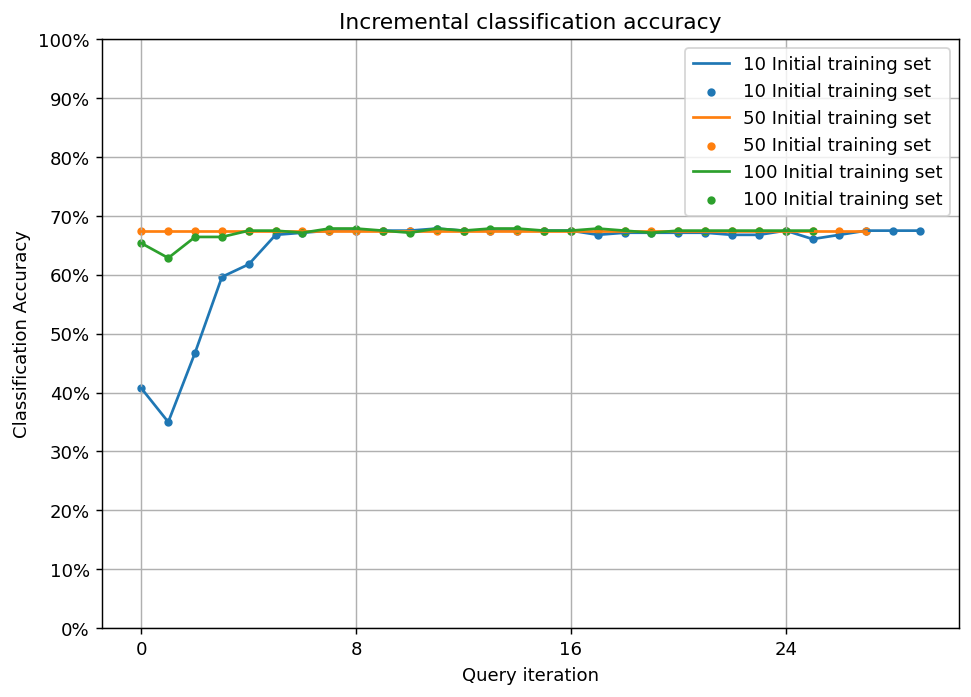

In [38]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.plot(performance_history_abortion,label="10 Initial training set")
ax.scatter(range(len(performance_history_abortion)), performance_history_abortion, s=13,label = "10 Initial training set")
ax.plot(performance_history_abortion1,label = "50 Initial training set")
ax.scatter(range(len(performance_history_abortion1)), performance_history_abortion1, s=13,label = "50 Initial training set")
ax.plot(performance_history_abortion2,label = "100 Initial training set")
ax.scatter(range(len(performance_history_abortion2)), performance_history_abortion2, s=13,label = "100 Initial training set")

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.show()